<br />

<h1 align="center">The</h1>
<h1 align="center">Natural Language Processing</h1>
<h5 align="center">of</h5>
<h1 align="center">South Africa's State of the Nation</h1>
<h1 align="center">Addresses</h1>
<h5 align="center">by</h5>
<h3 align="center">Monde Anna</h3>

<br />
<br />


<p>Within the following notebook, we will get to explore the priorities and challenges faced by our country over the last 24 years, that is, from the year 2000 up to and including the year 2023. Each president and as such each presidential term will offer us insight into said priorities as well as provide a launchpad from which to gain an insight into the core focuses of each presidential period term.</p>

<br />
<br />


<h3 align="Center">Sources</h3>

<br />

<ul>
    <br />
    <li>
        <a href="../assets/brief.md">Brief</a>
    </li>
    <br />
    <li><a href="https://www.gov.za/state-nation-address">SONA Speech Archive</a>
    </li>
</ul>

<br />
<br />


<h3 align="Center">Imports</h3>

<br />
<br />


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English as MakeEnglishNLP
from spacytextblob import spacytextblob
from matplotlib import pyplot as plt
from string import ascii_letters
from wordcloud import WordCloud
from collections import Counter
from string import punctuation
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import nltk
import bs4
import re


<br />

<h3 align="Center">Global Settings</h3>

<br />
<br />


In [2]:
BOLD = "bold"
FIG_18_32 = 18, 32
N_COLS = 4
N_ROWS = 7
SEED = 69

sns.set(rc={
    "axes.labelpad": 12,
    "axes.labelweight": BOLD,
    "axes.titlepad": 24,
    "axes.titlesize": 18,
    "axes.titleweight": BOLD,
    "figure.figsize": (12,6),
    "figure.titlesize": 32,
    "figure.titleweight": BOLD,
})

nltk_data = [
    "averaged_perceptron_tagger",
    "omw-1.4",
    "punkt",
    "stopwords",
    "tagsets",
    "wordnet",
]

for datum in nltk_data:
    nltk.download(datum, quiet=True)


<br />

<h2 align="Center">Data Acquisition</h2>

<br />
<br />

<p>With the use of the URL addresses provided in the <i>json</i> file accompanying this project, we will scrape the State of the Nation speech archive website for each transcript of the addresses as of the year 2000. Of particular importance to us are; <b><i>Date</i></b>, the <b><i>President</i></b> making the speech and the speech's <b><i>Transcript</i></b>.</p>

<br />
<br />
<br />


In [3]:
def get_president(soup):
    """focus is on 21st century presidents"""
    presidents = {
        "Mbeki": "Thabo Mbeki",
        "Motlanthe": "Kgalema Motlanthe",
        "Zuma": "Jacob Zuma",
        "Ramaphosa": "Cyril Ramaphosa",
    }

    title = "".join(t for t in soup.find(class_="title"))

    return "".join(
        presidents[pres]
        for pres in presidents.keys()
        if pres.lower() in title.lower()
    )


In [4]:
def get_date(soup):
    str_date = soup.find(class_="field-item even").text
    return datetime.strptime(str_date, "%d %b %Y").date()


In [5]:
def get_speech(soup):
    return " ".join(
        paragraph.text
        for paragraph
        in soup.find(class_="section section-content").find_all("p")
    )


In [6]:
def get_speech_from_url(url):
    page = requests.get(url).text
    soup = bs4.BeautifulSoup(page, "html.parser")

    return {
        "president": get_president(soup),
        "date": get_date(soup),
        "speech": get_speech(soup)
    }


In [7]:
with open("../assets/speech_urls.json", "r") as file:
    speech_urls = json.load(file)


In [8]:
flattened_urls = [
    url
    for year in speech_urls
    for urls in year.values()
    for url in urls
]


<br />

<h5 align="Center">Web Scrapping</h5>

<br />

<p>Sadly, our source website is slow and at times suffers a <i>504 Gateway Time-Out</i> error. As such, the scrapped data as modelled by the <i>get_speech_from_url</i> function above has been stored using Jupyter Notebook's magic method <b><i>%store</i></b> so as to allow for quick kernel restarts. Should there be a wish to refresh the data, in a new cell, run:
    <br>
    <br>
    <code>%store -d scrapped_speeches</code>
</p>

<br />
<br />


In [9]:
%%capture

%store -r scrapped_speeches

if "scrapped_speeches" not in globals() or len(scrapped_speeches) != len(flattened_urls):
    scrapped_speeches = [get_speech_from_url(url) for url in flattened_urls]
    %store scrapped_speeches


<br />

<h2 align="center">Text Preprocessing</h2>

<br />
<br />


<h3 align="Center">Data Cleaning</h3>

<br />

<p>In this section, we will move towards cleaning the newly acquired data. Of particular concern is ensuring that we:
    <ul>
        <li>Set all text to lowercase</li>
        <li>Prune digits</li>
        <li>Say goodbye to stop words</li>
        <li>Remove punctuation</li>
        <li>Tokenise and lemmatize the words</li>
        <li>From amongst all speeches, cull words that:
            <ol>
                <li>Occurs in the top ten list per speech, for every speech</li>
                <li>Offer little insight into the <b><i>State of the Nation</i></b>, such as removing:
                    <ul>
                        <li>Greetings</li>
                        <li>Obvious pleasantries</li>
                        <li>Titles</li>
                        <li>References to the chair of the house</li>
                        <li><i>etc...</i></li>
                    </ul>
                </li>
            </ol>
        </li>
    </ul>
</p>

<br />
<br />


In [10]:
with open("../assets/pos_wordnet_map.json", "r") as file:
    POS_MAP = json.load(file)


In [11]:
def lemmatize(speech, *, pos_map=POS_MAP):
    return [
        nltk.stem.WordNetLemmatizer().lemmatize(
            word=word,
            pos=pos_map.get(pos_tag, "n")
        )
        for word, pos_tag in nltk.pos_tag(speech)
    ]


In [12]:
def unique_word_counter(speeches):
    """ should 'speeches' be a list, then the length is found,
        elsewise, should 'speeches' be a string, said string is
        split at whitespaces, returning the element count of the
        returned collection object
    """
    return sum(
        _unique_word_counter_helper(speech)
        for speech in speeches
    )


def _unique_word_counter_helper(speech):
    if type(speech) == list:
        corrected_speech = set(speech)
    else:
        corrected_speech = set(re.split("\s", speech))
    return len(corrected_speech)


In [13]:
def deconcatenate_words(speech):
    """adds space when words have no spaces between them"""
    for match in re.findall("([a-z][A-Z])", speech):
        speech = re.sub(match, f"{match[0]} {match[1]}", speech)
    return speech


In [14]:
concat_speech = lambda speech: " ".join(speech)
remove_digits = lambda speech: re.sub("[\w|\s]*\d+[\w|\s]*", "", speech)
remove_punctuation = lambda speech: re.sub(f"[{punctuation}]+", " ", speech)
remove_stop_words = lambda speech, stop_words: [
    word for word in speech if word not in stop_words
]



<br />

<h3 align="Center">Corpus</h3>
<h5 align="Center">Initial</h5>

<br />
<br />


In [15]:
speeches = pd.DataFrame(scrapped_speeches)
speeches.set_index(keys="date", inplace=True)
speeches.head()


president                                             speech
date                                                                      
2000-02-04  Thabo Mbeki  Madame Speaker and Deputy Speaker,Chairperson ...
2001-02-09  Thabo Mbeki  Madame Speaker and Deputy Speaker,Deputy Presi...
2002-02-08  Thabo Mbeki  Madame Speaker and Deputy Speaker,Chairperson ...
2003-02-14  Thabo Mbeki  Madame Speaker of the National Assembly;Chairp...
2004-02-06  Thabo Mbeki  6 February 2004 Madame SpeakerChairperson of t...

<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Add Whitespace between Individual Words</h5>

<br />
<br />

<p>As with the <a href="https://www.gov.za/node/537677">first speech of 2004</a>, oftentimes the president begins by greeting the house. The transcript displays each greeting as a new line. Consequently, words get concatenated with no space or special character to mark where each word begins and the other ends. As luck would have it, the letter casing is left undamaged and here, we solve this issue.</p>

<br />
<br />


In [16]:
assert "SpeakerChairperson" in speeches.speech[4]
assert "ProvincesDeputy" in speeches.speech[4]


In [17]:
word_count_prior_deconcatination = unique_word_counter(speeches.speech)
speeches.speech = speeches.speech.apply(deconcatenate_words)
word_count_post_deconcatination = unique_word_counter(speeches.speech)


In [18]:
assert "SpeakerChairperson" not in speeches.speech[4]
assert "Speaker Chairperson" in speeches.speech[4]

assert "ProvincesDeputy" not in speeches.speech[4]
assert "Provinces Deputy" in speeches.speech[4]

assert word_count_prior_deconcatination < word_count_post_deconcatination, """\
expect deconcatination to increate word count"""


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Set Text to Lowercase</h5>

<br />
<br />


In [19]:
speeches.speech = speeches.speech.str.lower()


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Remove Digits</h5>

<br />
<br />


In [20]:
speeches.speech = speeches.speech.apply(remove_digits)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Removal of Punctuation</h5>

<br />
<br />


In [21]:
speeches.speech = speeches.speech.apply(remove_punctuation)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Tokenize Words</h5>

<br />
<br />


In [22]:
speeches.speech = speeches.speech.apply(nltk.word_tokenize)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Remove Stop Words</h5>

<br />
<br />


In [23]:
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_additional = ["mr", "mrs", "", " "]
stop_words = stop_words_nltk + stop_words_additional
stop_words.extend(ascii_letters)

speeches.speech = speeches.speech.apply(
    remove_stop_words, args=(stop_words,)
)


<br />

<h5 align="Center">Speeches</h5>
<h5 align="Center">Lemmatization</h5>

<br />
<br />

<p>Here we will use Part-of-Speech (POS) Tags to determine which words to apply lemmatization on. Follow the provided link for the complete <a href="https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html">Penn Treebank Project</a> list. In essence, the drive is to make words <b><i>singular</i></b> and <b><i>present tense</i></b>. A great limitation of our approach is that we mostly will garner great results with <i>ASCII</i> characters as well as have some success with <i>UTF-8</i> character sets; anything beyond, such as <a href="https://en.wikipedia.org/wiki/ISO/IEC_8859-1">ISO/IEC 8859-1</a>, may suffer as a result of this approach.</p>

<p>With great luck the prior preprocessing has left us with these variations:
    <ul>
        <li>Adjectives</li>
        <li>Adverbs</li>
        <li>Nouns</li>
        <li>Verbs</li>
    </ul>
</p>

<br />
<br />


In [24]:
assert "member" in speeches.speech[0] and "members" in speeches.speech[0]
assert "programme" in speeches.speech[0] and "programmes" in speeches.speech[0]


In [25]:
word_count_prior_lemmatization = unique_word_counter(speeches.speech)
speeches.speech = speeches.speech.apply(lemmatize).apply(lemmatize)
word_count_post_lemmatization = unique_word_counter(speeches.speech)


In [26]:
assert "members" not in speeches.speech[0]
assert "member" in speeches.speech[0]

assert "programmes" not in speeches.speech[0]
assert "programme" in speeches.speech[0]

assert word_count_post_lemmatization < word_count_prior_lemmatization, """\
expect reduced word count port lemmatization"""


<br />

<h3 align="Center">Corpus</h3>
<h5 align="Center">Interim</h5>

<br />
<br />


In [27]:
speeches["tokenized"] = speeches.speech.copy(deep=True)
speeches.speech = speeches.speech.apply(
    concat_speech
)

speeches.head()


president                                             speech  \
date                                                                         
2000-02-04  Thabo Mbeki  madame speaker deputy speaker chairperson depu...   
2001-02-09  Thabo Mbeki  madame speaker deputy speaker deputy president...   
2002-02-08  Thabo Mbeki  madame speaker deputy speaker chairperson depu...   
2003-02-14  Thabo Mbeki  madame speaker national assembly chairperson n...   
2004-02-06  Thabo Mbeki  general leader public service president mandel...   

                                                    tokenized  
date                                                           
2000-02-04  [madame, speaker, deputy, speaker, chairperson...  
2001-02-09  [madame, speaker, deputy, speaker, deputy, pre...  
2002-02-08  [madame, speaker, deputy, speaker, chairperson...  
2003-02-14  [madame, speaker, national, assembly, chairper...  
2004-02-06  [general, leader, public, service, president, ...

<br />

<h3 align="Center">Document-Term Matrix</h3>

<br />
<br />


In [28]:
vectorizer = CountVectorizer(stop_words="english")

vector = vectorizer.fit_transform(speeches.speech).toarray()

doc_term_matrix = pd.DataFrame(
    data=vector,
    index=speeches.index,
    columns=vectorizer.get_feature_names_out(),
)

doc_term_matrix.iloc[:5, :12]


aaron  aasroc  ab  aba  ababa  abadala  abadlwengula  abahlala  \
date                                                                         
2000-02-04      0       0   1    0      0        0             0         0   
2001-02-09      0       0   0    0      0        0             0         0   
2002-02-08      0       0   0    0      0        0             0         0   
2003-02-14      0       0   0    0      0        0             0         0   
2004-02-06      0       0   0    0      0        0             0         0   

            abahloniphekileyo  abakwenzayo  abalimi  abamhlophe  
date                                                             
2000-02-04                  0            0        0           0  
2001-02-09                  0            0        0           0  
2002-02-08                  0            0        0           0  
2003-02-14                  0            0        0           0  
2004-02-06                  0            0        0           0

<br />

<h3 align="center">Data Cleaning Cont.</h3>
<h5 align="center">Redundancies and Minimal Usage</h5>

<br />
<br />

<p>For the most part, formatting and removing none alphabetic characters looks to have been completed. To our benefit, the <i>Interim Corpus</i> offers a self-evident pattern; Thabo Mbeki tends to start his speeches in a similar way, as such we should be wary of words/phrases being repeated between documents and perhaps even within a document — yet offering little relation to any core insights that may be drawn from the speech.</p>

<p>Arbitrarily, (a) the <i>Top-Ten</i> reoccurring words between the speeches will be our target as well as (b) senseless words with regard to the core subject matter; The State of the Nation. (c) Finally, should a word be used less than three times across all speeches, it too shall be removed.</p>

<p>Let us attend to these matters.</p>

<br />
<br />


In [29]:
def get_redundant_words(dtm, word_finder, end_year_iloc=-1):
    this_year = dtm.index[end_year_iloc]
    
    if this_year == dtm.index[0]:
        return word_finder(dtm=dtm, year=this_year)

    return word_finder(dtm=dtm, year=this_year).intersection(
        get_redundant_words(
            dtm=dtm, 
            word_finder=word_finder,
            end_year_iloc=end_year_iloc-1
        )
    )


In [30]:
def get_set_of_words_from_current_year(dtm, year):
    used_words_mask = dtm.loc[year] > 0
    used_words = dtm.loc[year][used_words_mask].index
    return set(used_words)


In [31]:
def get_set_of_top_ten_words_for_the_year(dtm, year):
    top_ten_words = dtm.loc[year].nlargest(10).index.to_list()
    return set(top_ten_words)


<br />

<h5 align="center">Finding Top-Ten Redundancies</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />

</p>In plain English, we will:
    <ul>
        <li>Take the <i>Top-Ten</i> words per speech</li>
        <li>Use set intersection while recursing from the latest to the oldest speech</li>
        <li>The remaining words will have logically been at the <i>Top-Ten</i> of each speech in order for said words to carry over the chained intersections</li>
    </ul>
</p>

<br />
<br />


In [32]:
assert not get_redundant_words(
    dtm=doc_term_matrix,
    word_finder=get_set_of_top_ten_words_for_the_year,
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>Recall, there are 28 speeches between the years 2000 and 2023, inclusive</li>
    <br />
    <li>Each year's <i>Top-Ten</i> creates the base from which to remove words that are not repeated in the list from the previous year.</li>
    <br />
    <li>One of the great benefits is that this becomes an approximately <i>O(n<sup>2</sup>)</i> operation as opposed to <i>O(n<sup>n</sup>)</i>; this occurs because each year is compared to fewer words in an established set, versus a new set.</li>
    <br />
    <li>As per the assertion above, there are no words that appear in the <i>Top-Ten</i> of each year, every year</li>
</ul>

<br />
<br />


<h5 align="center">Finding Senseless Redundancies</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />

</p>As far as the meaningless words:
    <ul>
        <li>We will take all words per speech</li>
        <li>Recursively cull words that do not appear in each speech</li>
        <li>Make a quick manual selection of words that we qualify as meaningless</li>
    </ul>
</p>

<br />
<br />


In [33]:
words_in_all_speeches = get_redundant_words(
    dtm=doc_term_matrix,
    word_finder=get_set_of_words_from_current_year,
)

words_in_all_speeches = sorted(words_in_all_speeches)

ncols = len(words_in_all_speeches) / N_ROWS
ncols = np.math.ceil(ncols)

while (len(words_in_all_speeches) // N_ROWS) < ncols:
    words_in_all_speeches.append("-")

words_in_all_speeches = np.array(
    words_in_all_speeches
).reshape(N_ROWS, ncols)

pd.DataFrame(
    data=words_in_all_speeches,
    index=[" "] * N_ROWS,
    columns=[" "] * ncols,
)


\
        action  address          africa   african       area           build   
       country   create     development  economic    economy       education   
        health     high  implementation   improve    include  infrastructure   
          lead     life            like     local       make          member   
   partnership   people           place    policy  president         private   
      resource   sector        security   service      small          social   
         thank     time           union     woman       work           world   

                                                    
      business  challenge   community     continue  
        ensure       good  government       growth  
   institution      issue         job         land  
      national       need         new  opportunity  
     programme    provide    province       public  
         south      state  strengthen      support  
          year          -           -            -

<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li><b><i>Address</i></b>, <b><i>Africa(n)</i></b>, <b><i>Country</i></b>, <b><i>National</i></b>, <b><i>President</i></b>, <b><i>South</i></b> and <b><i>Thank</i></b> all look to be fillers within the speeches</li>
    <br />
    <li>The words <b><i>Action</i></b>, <b><i>Build</i></b>, <b><i>Create</i></b> and <b><i>Make</i></b> can be said to be synonyms, as such I will be keeping <b><i>Build</i></b> as I find it easier to apply to abstract concepts such as <i>"build a sense of unity"</i> as well as more concrete concerns such as <i>"in building more concrete and sustainable sources of energy, we offer ourselves an easier time at building the wealth and prosperity of our country"</i></li>
    <br />
    <li>The words <b><i>Like</i></b> and <b><i>Year</i></b> feel as though they fell through the cracks during the initial removal of stop words</li>
</ul>

<br />
<br />


In [34]:
fillers = [
    "address",
    "africa",
    "african",
    "country",
    "national",
    "president",
    "south",
    "thank"
]

synonyms_ = [
    "action",
    "create",
    "make"
]

misc_words = ["like", "year"]


<br />

<h5 align="center">Finding Words Used Less Than Three Times</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />


In [35]:
less_than_three_uses = [
    index
    for index, is_less_than_three
    in (doc_term_matrix.sum() < 3).items()
    if is_less_than_three
]


<br />

<h5 align="center">Culling Redundancies and Minimally Used Words</h5>
<h5 align="Center">Across All Speeches</h5>

<br />
<br />


In [36]:
for list_ in [fillers, synonyms_, misc_words, less_than_three_uses]:
    stop_words.extend(list_)

speeches.tokenized = speeches.tokenized.apply(
    remove_stop_words, args=(stop_words,)
)


In [37]:
dtm_len_prior_cull = doc_term_matrix.shape[1]

dtm_feat_to_cull = [
    word
    for word in stop_words
    if word in doc_term_matrix.columns
]

doc_term_matrix.drop(columns=dtm_feat_to_cull, inplace=True)
dtm_len_post_cull = doc_term_matrix.shape[1]

assert dtm_len_prior_cull > dtm_len_post_cull

speeches.speech = speeches.tokenized.apply(
    concat_speech
)


<br />

<h2 align="center">Data Analysis</h2>

<br />
<br />


<h3 align="Center">Descriptive Statistics</h3>
<h3 align="Center">Analyses Individuated</h3>
<h5 align="Center">by</h5>
<h3 align="Center">President</h3>

<br />
<br />


In [38]:
descriptive_stats = [
    pd.Series(
        data={
            "president": pd.Series(speeches.president[year]).values[0],
            "mode": pd.Series(speeches.tokenized[year]).mode().values[0],
            "count": pd.Series(speeches.tokenized[year]).shape[0],
            "nunique": pd.Series(speeches.tokenized[year]).nunique(),
        },
        name=year,
    )
    for year in speeches.index
]


<br />

<h5 align="Center">Descriptive Statistics</h5>
<h5 align="Center">Thabo Mbeki</h5>

<br />
<br />


In [39]:
pd.DataFrame(descriptive_stats).T.iloc[:, :10]


2000-02-04   2001-02-09   2002-02-08   2003-02-14   2004-02-06  \
president  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki   
mode        government   government   government   government       people   
count             2563         2758         3468         4177         2501   
nunique            994         1059         1194         1317          978   

            2004-05-21   2005-02-11   2006-02-06   2007-02-09   2008-02-08  
president  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki  Thabo Mbeki  
mode       development   government   government      improve   government  
count             1890         3307         3350         2974         3084  
nunique            819         1155         1217         1167         1122

<br />

<h5 align="Center">Observations With Regard to Thabo Mbeki</h5>

<br />

<ul>
    <li>Both terms by <b><i>Thabo Mbeki</i></b> have a primary focus on the <b><i>Government</i></b> and with words such as <b><i>People</i></b> as well as <b><i>Improve</i></b> having been the mode on two occassions I would say the this presidency was focused on the betterment of South Africa</li>
    <br />
    <li>As the years go by, unique and total word count increases, of more interest is how there is an increase in wordage around large world events. <b><i>2002</i></b> followed the fallout of <b><i>9-11</i></b>, <b><i>2006</i>, the world cup</b> and <b><i>2008</i></b> saw a combination of <b><i>Thabo Mbeki's</i></b> last year in office as well as the American Housing Market Crash of '08</li>
    <br />
    <li><b><i>2004-05-21</i></b> is a lovely outlier, the speech follows the <b><i>2004</i></b> General Elections and here we find the lowest count, both in terms of unique words and the total of used words</li>
</ul>

<br />
<br />


<h5 align="Center">Descriptive Statistics</h5>
<h5 align="Center">kgalema Motlanthe &amp; Jacob Zuma</h5>

<br />
<br />


In [40]:
pd.DataFrame(descriptive_stats).T.iloc[:, 10:21]


2009-02-06  2009-06-03  2010-02-11  2011-02-10  2012-02-09  \
president  Kgalema Motlanthe  Jacob Zuma  Jacob Zuma  Jacob Zuma  Jacob Zuma   
mode                  people        work        work  government        also   
count                   3187        2152        1827        2222        2115   
nunique                 1227         919         833         984         922   

           2013-02-14  2014-02-13    2014-06-17  2015-02-12  2016-02-11  \
president  Jacob Zuma  Jacob Zuma    Jacob Zuma  Jacob Zuma  Jacob Zuma   
mode       honourable        also  municipality        also  compatriot   
count            2264        2248          2030        1935        2149   
nunique          1029        1004           836         905         988   

           2017-02-09  
president  Jacob Zuma  
mode       government  
count            2368  
nunique          1044

<br />

<h5 align="Center">Observations With Regard to Kgalema Motlanthe &amp; Jacob Zuma</h5>

<br />

<ul>
    <li><b><i>Kgalema Motlanthe</i></b> has but one speech, focusing on the subject of <b><i>People</i></b>. His unique word count is higher than that of <b><i>Jacob Zuma</i></b> and all but one of <b><i>Thabo Mbeki's</i></b></li>
    <br />
    <li><b><i>Jacob Zuma</i></b> shows incredible consistency in the total count of used words, averaging around 2 200 per speech. The speeches of <b><i>2010</i></b>, post General Elections of <b><i>2014</i></b>as well as that of <b><i>2015</i></b> come in lower than this, at worst being at approx. 1 800 words</li>
    <br />
    <li>The unique word count shows a similar pattern as above with the counts being well under a thousand. Three years counter this observation, with <b><i>2017</i></b>, the last year in office, showing the largest unique word count in conjunction with the largest total word count</li>
    <br />
    <li>Words such as <b><i>Work</i></b> and <b><i>Government</i></b> show up as the most used, yet amusingly so too does the word <b><i>Also</i></b> show up on three occasions</li>
    <br />
    <li>There are rather unexpected words such as <b><i>Honourable</i></b> and <b><i>Compatriot</i></b> showing up in the <b><i>Top-Five</i></b>, one wonders: Is this as a result of greeting the house or the president referring to a time of highly visible corruption?</li>
</ul>

<br />
<br />


<h5 align="Center">Descriptive Statistics</h5>
<h5 align="Center">Cyril Ramaphosa</h5>

<br />
<br />


In [41]:
pd.DataFrame(descriptive_stats).T.iloc[:, 21:]


2018-02-16       2019-02-07       2019-06-20       2020-02-13  \
president  Cyril Ramaphosa  Cyril Ramaphosa  Cyril Ramaphosa  Cyril Ramaphosa   
mode                people             work           people             work   
count                 2721             3971             2952             3241   
nunique               1032             1335             1157             1186   

                2021-02-11       2022-02-10       2023-02-09  
president  Cyril Ramaphosa  Cyril Ramaphosa  Cyril Ramaphosa  
mode                  work            state             work  
count                 2866             3553             3662  
nunique               1118             1223             1250

<br />

<h5 align="Center">Observations With Regard to Cyril Ramaphosa</h5>

<br />

<ul>
    <li>As with <b><i>Jacob Zuma</i></b>, we see consistency in delivery; both the total count of used words and that of unique words have little ebb-and-flow.</li>
    <br />
    <li>With regard to the subject matter, the focus is on <b><i>Work</i></b> and  <b><i>People</i></b></li>
</ul>

<br />
<br />


<h3 align="Center">Data Cleaning Continued</h3>

<br />
<br />


<h5 align="center">Jacob Zuma</h5>
<h5 align="Center">Remove the word "Also"</h5>

<br />
<br />


In [42]:
speeches.tokenized = speeches.tokenized.apply(
    remove_stop_words, args=("also",)
)


<br />

<h3 align="Center">Speech Complexity</h3>
<h3 align="Center">Individuated</h3>
<h5 align="Center">by</h5>
<h3 align="Center">President</h3>

<br />

<p>For a more fine-tuned understanding of each speech, we will focus on the length and accompanying complexity of each speech paired with the speaker. We will look for which president has so far, on average, used the average and absolute most count of words. Obviously, in order to come up with averages, we will have to take into account the number of speeches made by each.</p>

<br />
<br />


In [43]:
def get_word_count(speeches, president):
    total_words = [
        word
        for speech in _presidents_speeches(speeches, president)
        for word in speech
    ]
    return {
        "total_word_count": len(total_words),
        "total_unique_word_count": len(set(total_words)),
    }


def _presidents_speeches(speeches, president):
    mask = speeches.president == president
    return speeches[mask].tokenized


In [44]:
number_of_speeches = speeches.president.value_counts()
number_of_speeches.name = "number_of_speeches"

word_count = pd.DataFrame(
    data={
        president: get_word_count(speeches, president)
        for president in speeches.president.unique()
    },
).T

average_word_count = pd.DataFrame(
    data={
        "average_word_count": word_count.total_word_count / number_of_speeches,
        "average_unique_word_count": word_count.total_unique_word_count / number_of_speeches
    }
)

pd.concat(
    objs=[
        number_of_speeches,
        word_count,
        average_word_count,
    ],
    axis="columns",
)


number_of_speeches  total_word_count  \
Thabo Mbeki                        10             29843   
Jacob Zuma                         10             21083   
Cyril Ramaphosa                     7             22884   
Kgalema Motlanthe                   1              3162   

                   total_unique_word_count  average_word_count  \
Thabo Mbeki                           2818         2984.300000   
Jacob Zuma                            2614         2108.300000   
Cyril Ramaphosa                       2517         3269.142857   
Kgalema Motlanthe                     1225         3162.000000   

                   average_unique_word_count  
Thabo Mbeki                       281.800000  
Jacob Zuma                        261.400000  
Cyril Ramaphosa                   359.571429  
Kgalema Motlanthe                1225.000000

<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>With regards to which president has used the most number of words, ordered from most to least (this method is used throughout) , we have:
        <ul>
            <li>Thabo Mbeki</li>
            <li>Cyril Ramaphosa</li>
            <li>Jacob Zuma</li>
            <li>Kgalema Motlanthe</li>
        </ul>
    </li>
    <br />
    <li>The total unique word count has Ramaphosa and Zuma switching places</li>
    <br />
    <li>Of particular interest are the normalised counts, this is helpful as Zuma and Mbeki both have had 10 speeches, with Ramaphosa having made 7 and the outlier being Motlanthe due to his interim presidency</li>
    <br />
    <li>The ordering as per the averaged total word count is (<i>note:</i> little conclusions can be drawn from the following):
        <ul>
            <li>Cyril Ramaphosa</li>
            <li>Kgalema Motlanthe</li>
            <li>Thabo Mbeki</li>
            <li>Jacob Zuma</li>
        </ul>
    </li>
    <br />
    <li>The averaged unique word count is as follows:
        <ul>
            <li>Kgalema Motlanthe</li>
            <li>Cyril Ramaphosa</li>
            <li>Thabo Mbeki</li>
            <li>Jacob Zuma</li>
        </ul>
    </li>
    <br />
    <li>One may be so inclined as to conclude that due to each president's vocabulary, the unique word count is likely to drop as more speeches are made. Of future interest is whether or not Ramaphosa's count will drop should he also get to make ten speeches</li>
</ul>

<br />
<br />


<h3 align="Center">Visualise Top 5 Words</h3>
<h5 align="Center">Per Speech</h5>

<br />
<br />


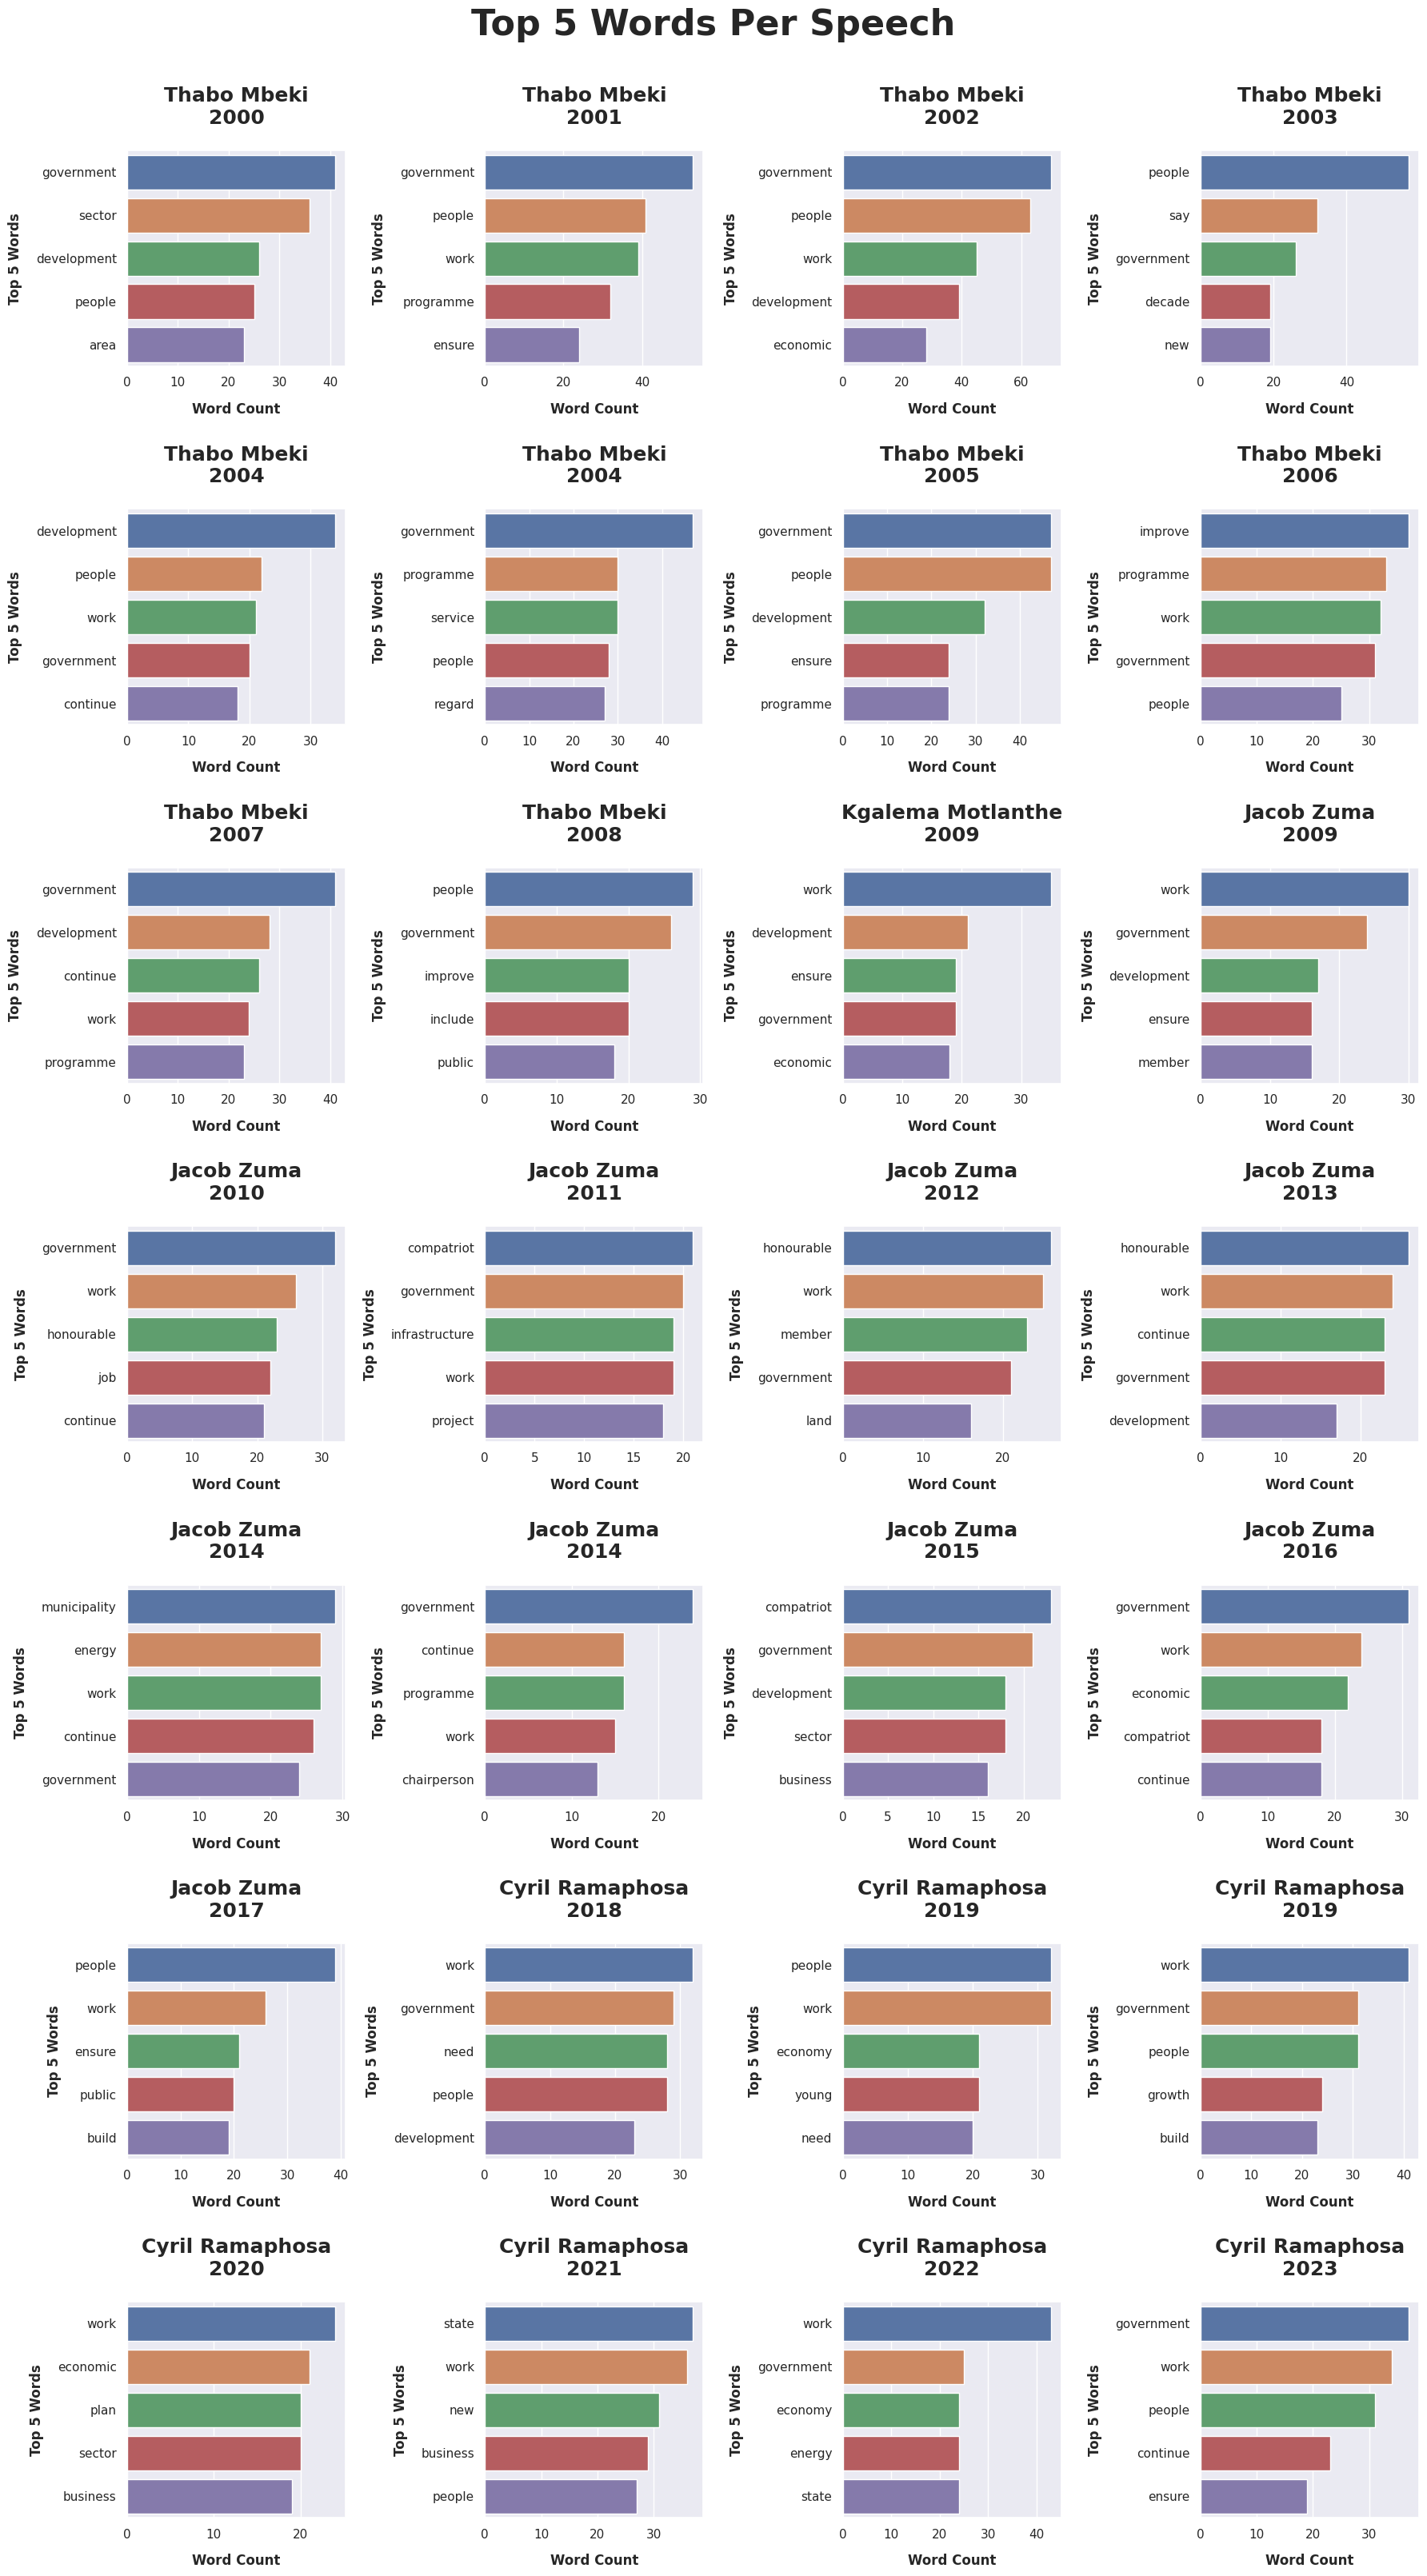

In [45]:
fig_01, _ = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIG_18_32)

for index, year in enumerate(doc_term_matrix.index, start=1):
    five_most_frequent = doc_term_matrix.loc[year].nlargest(5)
    sns.barplot(
        x=five_most_frequent.values,
        y=five_most_frequent.index,
    )
    
    plt.subplot(N_ROWS, N_COLS, index)

    president = speeches.loc[year].president
    plt.title(f"{president}\n{year.year}")

    plt.xlabel("Word Count")
    plt.ylabel("Top 5 Words")

fig_01.suptitle(t="Top 5 Words Per Speech", y=1.006)

plt.tight_layout(h_pad=2.125)
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>As evidenced above, the <b><i>Top-Five</i></b> most occurring words per year look to be sensible</li>
    <br />
    <li>Without going into too much detail, there looks to be a pattern
       arising, such as there being a constant presence of <b><i>Government</i></b>, <b><i>People</i></b> and <b><i>Work</i></b> being present in the earlier speeches</li>
    <br />
    <li>Here, with regard to <b><i>Jacob Zuma</i></b>, we further see how deeply entrenched the words <b><i>Honourable</i></b> and <b><i>Compatriot</i></b> are</li>
</ul>

<br />
<br />


<h3 align="Center">Word Cloud of Top 50 Words</h3>
<h5 align="Center">Per Speech</h5>

<br />
<br />


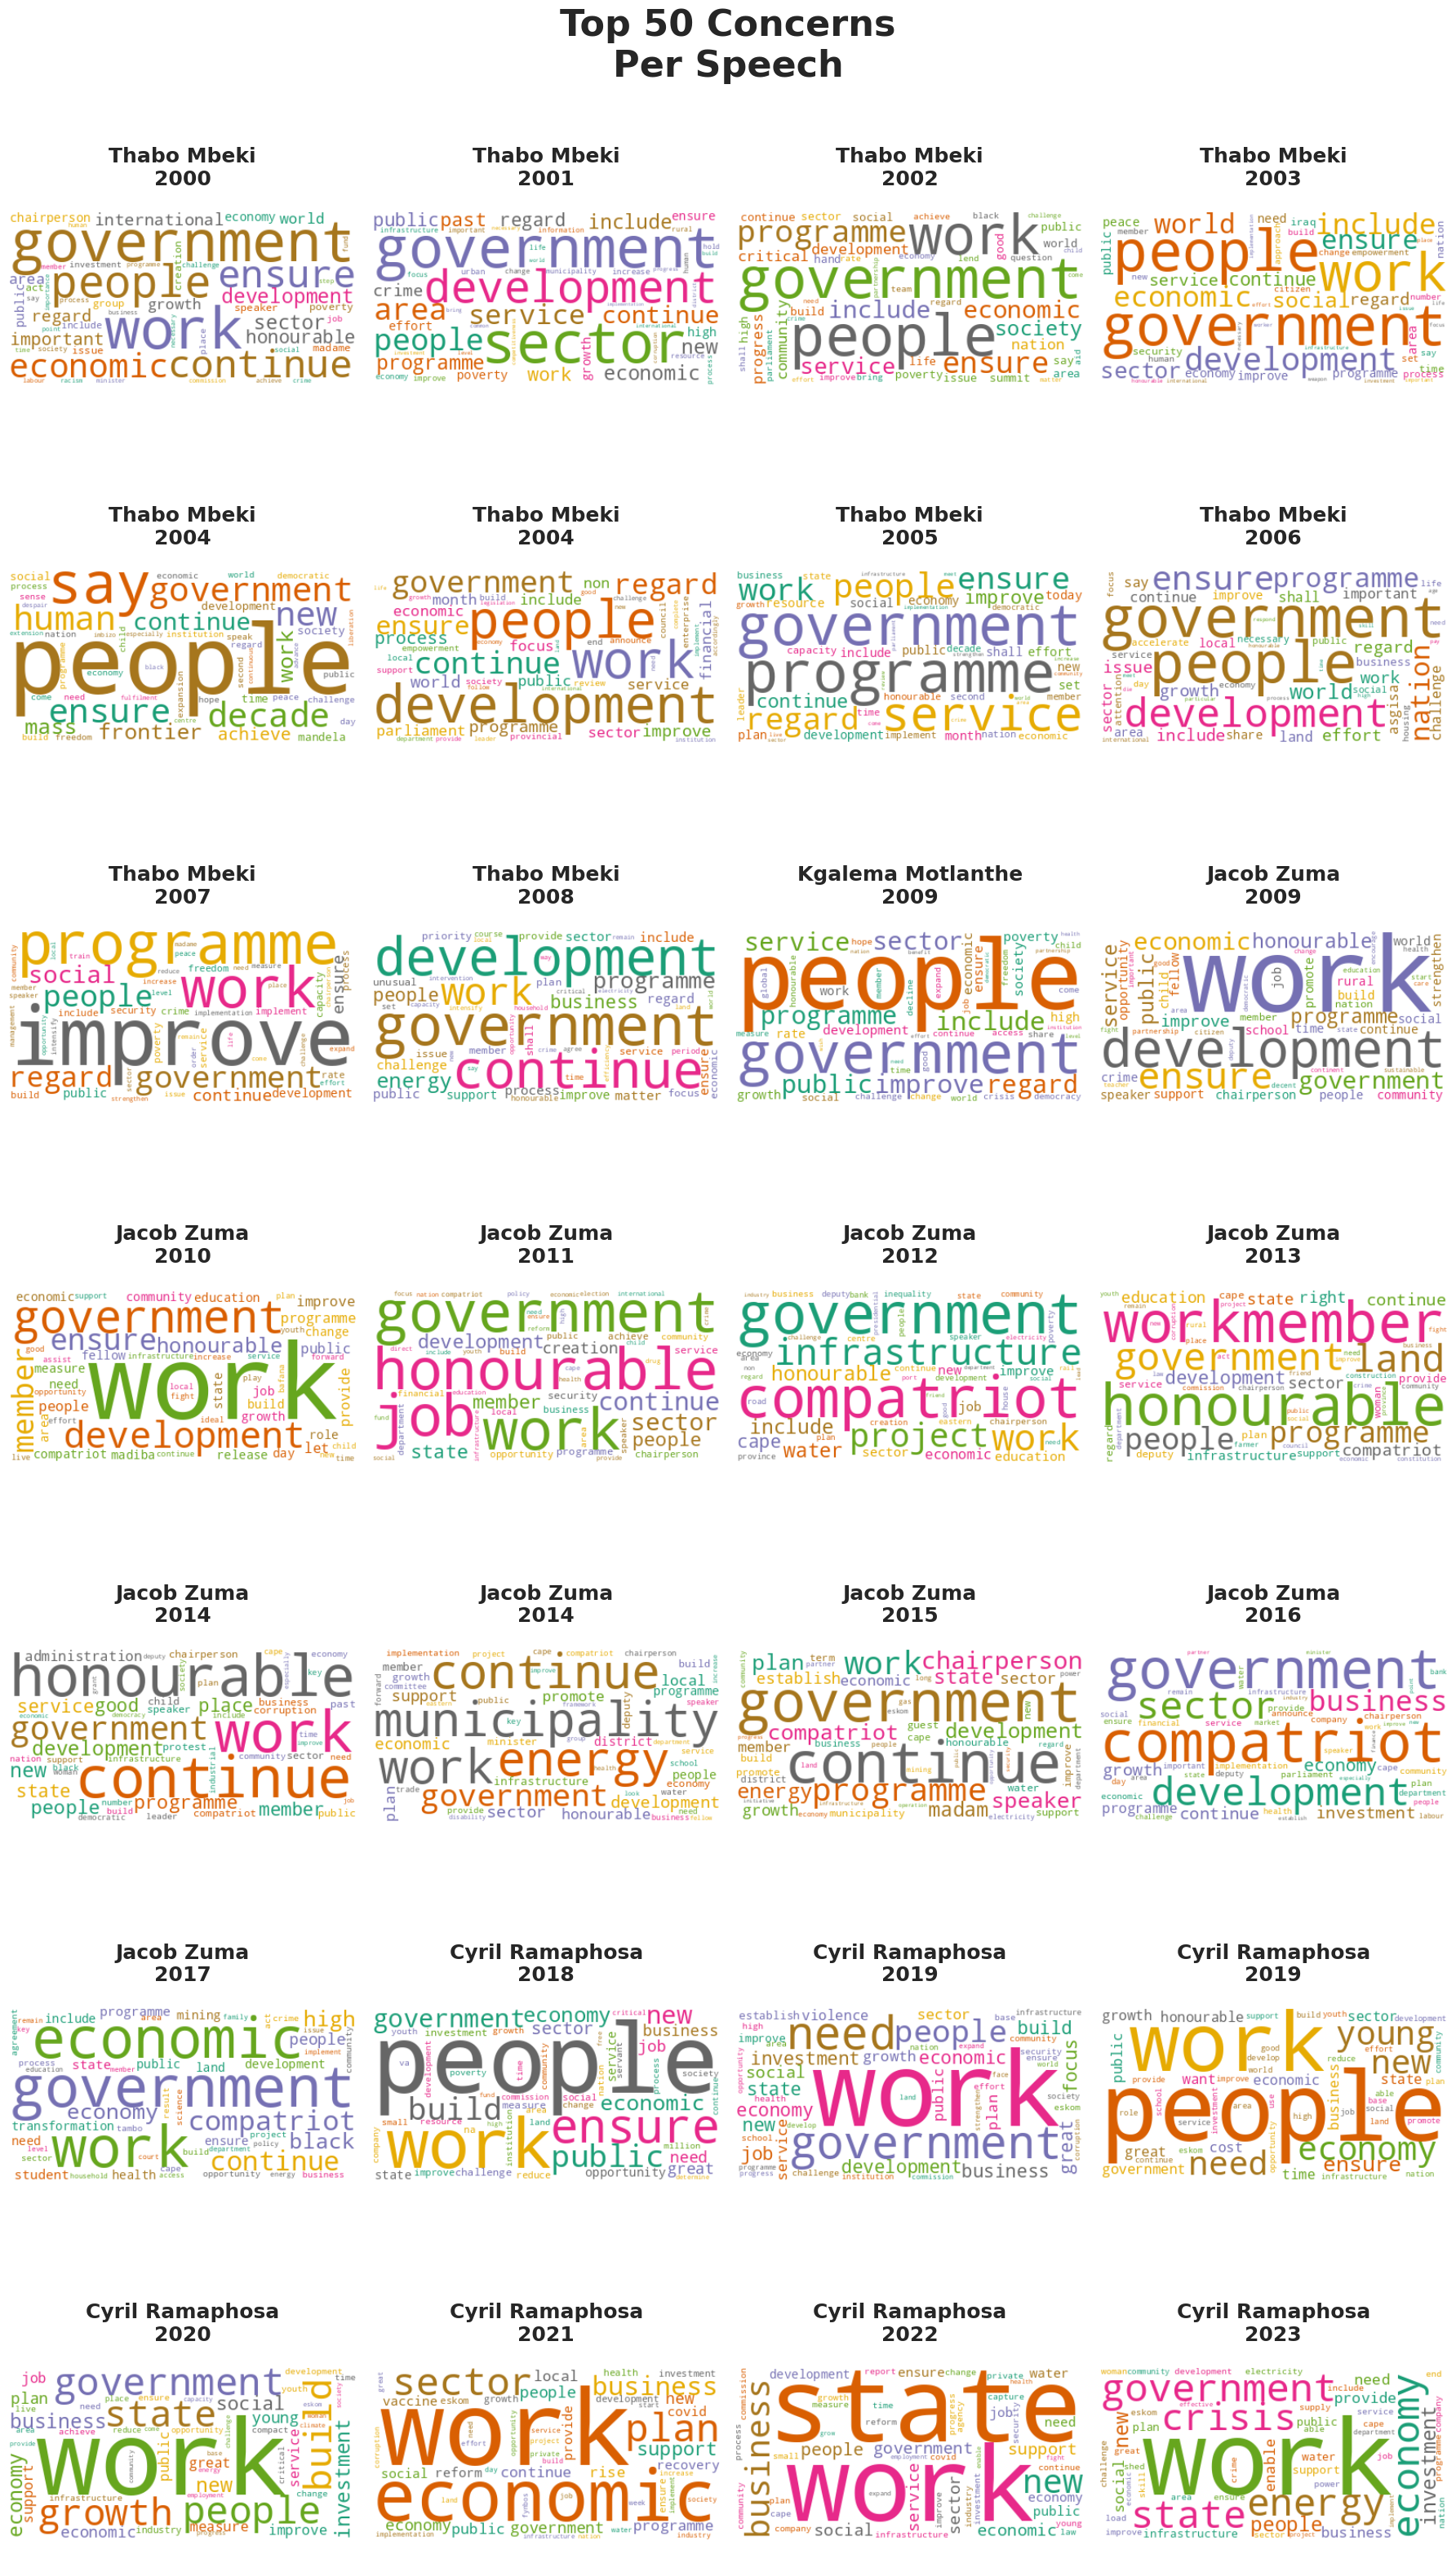

In [46]:
word_cloud = WordCloud(
    stopwords=stop_words,
    background_color="white",
    colormap="Dark2",
    max_font_size=120,
    random_state=SEED,
)

fig_02, _ = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=FIG_18_32)

for index, year in enumerate(doc_term_matrix.index, start=1):
    word_cloud.generate(
        " ".join(doc_term_matrix.loc[year].nlargest(50).index)
    )
    
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis("off")
    plt.imshow(
        X=word_cloud,
        interpolation="bilinear",
        interpolation_stage="rgba"
    )

    president = speeches.loc[year].president
    plt.title(f"{president}\n{year.year}")

fig_02.suptitle(t="Top 50 Concerns\nPer Speech", y=1.006)

plt.tight_layout(h_pad=6.125)
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>This follows the same pattern as the <b><i>Top-Five</i></b> words</li>
    <br />
    <li>Note the theme of repetitiousness; for instance, the year <b><i>2021</i></b> has <i>work</i>, <i>economic</i>, <i>sector</i>, <i>plan</i> and <i>business</i> as standout words, yet all these could be said to mean the same thing, perhaps an analysis ss per president may offer more insight</li>
    <br />
    <li><b><i>Thabo Mbeki:</i></b>
        <ul>
            <li>Herein we see a strong focus on the <b><i>Government</i></b> and what looks to be service delivery; this echoes the observations from the <i>descriptive statistics</i> section</li>
            <li>Along with this, <b><i>Development</i></b> is another hot topic and considering that the <b><i>Economy</i></b> is often mentioned, one may guess that <b><i>Development</i></b> relates to the <b><i>Nation</i></b> as well as its position in the world</li>
            <li>The strong emphasis on <b><i>People</i></b> implies wholly inclusive and paternal stewardship during this presidency, though I may be biased</li>
            <li>Note how in 2008, there is a little speck referring to <b><i>Energy</i></b>, considering that at this time the plan was to build a <a href="https://www.world-nuclear-news.org/Articles/Eskom-to-sign-new-plant-deal-in-2008">nuclear power plant</a>, it is quite a surprise that this got so little attention</li>
        </ul>
    </li>
    <br />
    <li><b><i>Kgalema Motlanthe:</i></b>
        <ul>
            <li>This looks to be a replica and summation of the speeches <b><i>Mbeki</i></b> made</li>
            <li>Of primary emphasis is <b><i>People</i></b></li>
            <li>Secondarily, we have <b><i>Government</i></b> making an appearance</li>
            <li><b><i>Improve</i></b>, <b><i>Include</i></b> and <b><i>Public</i></b> look tied for the third position, with further emphasis on the initial point — again, this looks to be a continuation of <b><i>Mbeki</i></b></li>
        </ul>
    </li>
    <br />
    <li><b><i>Jacob Zuma:</i></b>
        <ul>
            <li><b><i>Work</i></b>-<b><i>Work</i></b>-<b><i>Work</i></b>, this really jumps out at you</li>
            <li>During this term, unemployment reportedly <a href="https://borgenproject.org/zumas-imprisonment/#:~:text=One%20of%20the%20major%20criticisms,high%20and%20businesses%20were%20failing">increased by 25%</a> and interestingly the mention of <b><i>Work</i></b> began to take a back seat as the years went by — <i>note:</i> this presidency began during the global recession of 2008, for emphasis, these are but observations</li>
            <li>All else looks to be in keeping with the prior presidencies, really setting a theme</li>
            <li>Though in his <b><i>Top-Five</i></b>, <b><i>Energy</i></b> does not make the wordclouds</li>
            <li>Interesting additions to the theme are be <b><i>Infrastructure</i></b>, <b><i>Municipalities</i></b> and <b><i>Business</i></b>. Considering that the <a href="https://www.iol.co.za/news/politics/infrastructure-spending-quadrupled-zuma-1870533">2015 World Economic Forum</a> focused on Infrastural Development it makes sense that these appear later in the presidency</li>
        </ul>
    </li>
    <br />
    <li><b><i>Cyril Ramaphosa:</i></b>
        <ul>
            <li>Thematically, these speeches look to be no different from themselves or the other presidents'</li>
            <li><b><i>State</i></b>, <b><i>Governemnt</i></b>, <b><i>People</i></b>, <b><i>Economy</i></b> and so forth look to be but blunt variance of a theme; I would assume a sentimental analysis with little deviation</li>
            <li>Focusing on the year 2023, should we set aside <b><i>Work</i></b> and <b><i>Government</i></b>, then what stands out, in no particular order, are <b><i>Economy</i></b>, <b><i>Energy</i></b> <b><i>Crisis</i></b>, <b><i>Investment</i></b>, <b><i>People</i></b>, <b><i>Infrastructure</i></b>, <b><i>Need</i></b>, <b><i>Social</i></b> and <b><i>Business</i></b>
            </li>
            <li>With the above, one would expect a negative sentiment analysis for 2023</li>
        </ul>
    </li>
</ul>

<br />
<br />


<h3 align="center">Sentiment Analysis</h3>
<h5 align="center">Across All Speeches</h5>

<br />
<br />

<p>Before jumping in, a quick recap. For ease of interpretation, sentiment is broken down into two parts:
    <ol>
         <li>Subjectivity
            <ul>
                <li>This ranges from 0 to +1, similar to scaled values such as <i>MinMaxScalar</i></li>
                <li>At zero, the wording is said to be composed purely of facts; and</li>
                <li>At one, composed purely of subjective words, akin to saying: <i>"I like liking to like likeable words"</i></li>
            </ul>
        </li>
        <br />
       <li>Polarity
            <ul>
                <li>This ranges from -1 to +1, similar to <i>probability</i></li>
                <li>At the extremes (-1 or +1), we are informed that the wording shows a great intensity; almost akin to stating that one is impassioned</li>
                <li>Zero means no intensity, again, similar to <i>probability</i></li>
            </ul>
        </li>
    </ol>
</p>

<br />
<br />


In [47]:
def plot_sentiment(source, sentiment, president):
    ylabel = "Intensity of View Point" if sentiment == "polarity" else "Fact to Opinion Ratio"

    sentiment_plot = sns.lineplot(
        x=source.index,
        y=source[sentiment]
    ).set(
        title=f"{sentiment.title()} Visualised",
        xlabel="Year",
        ylabel=ylabel,
    )

    sns.lineplot(x=source.index, y=np.mean(source[sentiment]))

    plt.suptitle(president.title(), x=0.525)
    plt.tight_layout()
    plt.show()


polarity = "polarity"
subjectivity = "subjectivity"


<br />

<h5 align="center">Generate Sentiment</h5>

<br />
<br />


In [48]:
english_nlp = MakeEnglishNLP()
english_nlp.add_pipe("spacytextblob")


speeches["polarity"] = speeches.speech.apply(
    lambda speech: english_nlp(speech)._.blob.polarity
)

speeches["subjectivity"] = speeches.speech.apply(
    lambda words: english_nlp(words)._.blob.subjectivity
)


<br />

<h5 align="center">All Presidents</h5>
<h5 align="center">Subjectivity</h5>

<br />
<br />


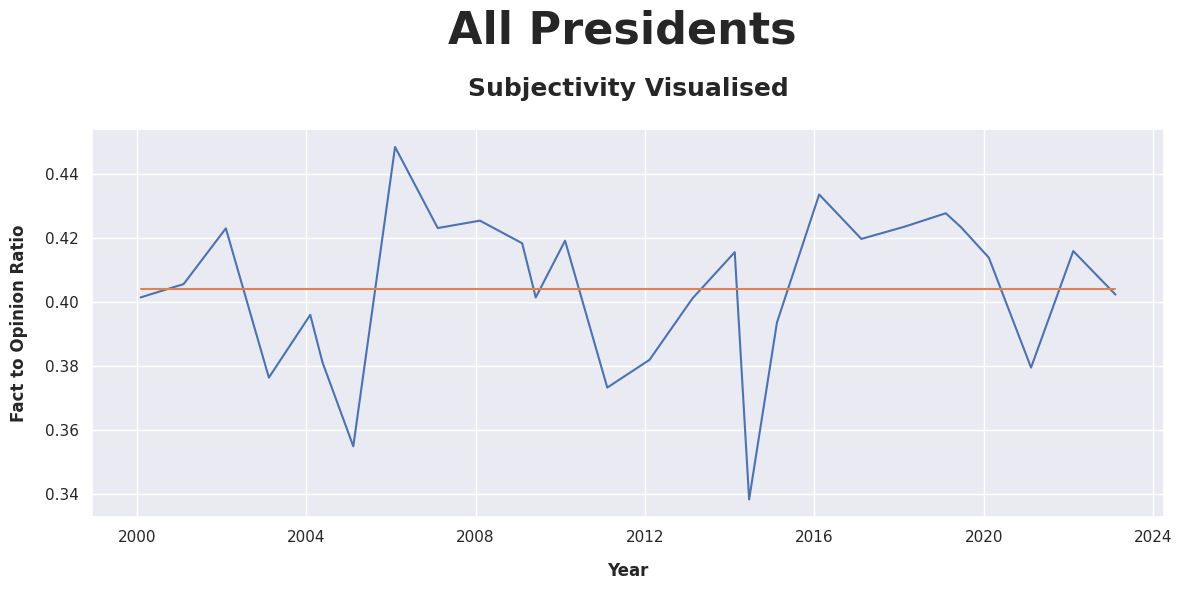

In [49]:
plot_sentiment(
    source=speeches,
    sentiment=subjectivity,
    president="All Presidents",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>By eye, <b><i>Subjectivity</i></b> looks to have averaged at about <b><i>41%</i></b> with a deviation of roughly <b><i>4%</i></b> over the years</li>
    <br />
    <li>One year after an election, <b><i>Subjectivity</i></b> drops, with 2014 being a milestone, something in the region of <b><i>-6%</i></b></li>
    <br />
    <li>As per the high average of roughly <b><i>4%</i></b>, the looks to be a balance between fact and opinion with a minor dip towards facts</li>
    <br />
    <li>With our definition in mind, we can see that throughout all terms, the speeches have been more fact than opinion, though the shift is quite small. Speeches following General Election usually see an increase in factual content. In two speeches from a General Election, we see peeks into opinion within a speech, though even these speeches are more fact than opinion</li>
</ul>

<br />
<br />


<h5 align="center">All Presidents</h5>
<h5 align="center">Polarity</h5>

<br />
<br />


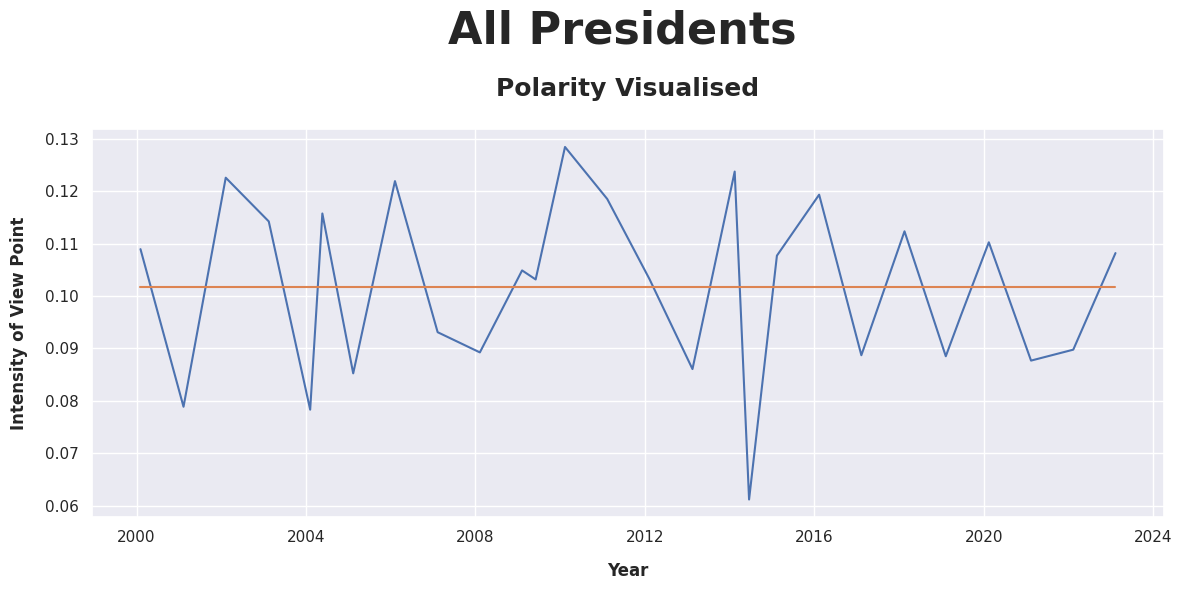

In [50]:
plot_sentiment(
    source=speeches,
    sentiment=polarity,
    president="All Presidents",    
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li><b><i>Polarity</i></b> too looks to have a narrow range averaged at about <b><i>10%</i></b> with a deviation of <b><i>2%</i></b></li>
    <br />
    <li>Election years tend to go hand in hand with <b><i>Polarity</i></b>, though there isn't enough data to make this a solid claim</li>
    <br />
    <li>Again, as with <b><i>Subjectivity</i></b>, the 2014 elections look to have a milestone of a dip at about <b><i>-4%</i></b></li>
    <br />
    <li>All in all, we see what averages out to be an ever so slightly positive sentiment, with each year showing upward and downward shifts, yet remaining positive. General Elections are usually followed by a reduction in positivity. <b><i>2010</i></b>, the year most remembered as having South Africa place host to the World Cup has the highest measure of positivity</li>
</ul>

<br />
<br />


<h3 align="center">Sentiment Analysis</h3>
<h3 align="Center">Individuated</h3>
<h5 align="center">by</h5>
<h3 align="center">President</h3>

<br />
<br />


In [51]:
def get_presidential_sentiment(speeches, president):
    mask = speeches.president == president
    return speeches[mask][["polarity", "subjectivity"]]


<br />

<h5 align="center">Thabo Mbeki</h5>
<h5 align="center">Subjectivity</h5>

<br />
<br />


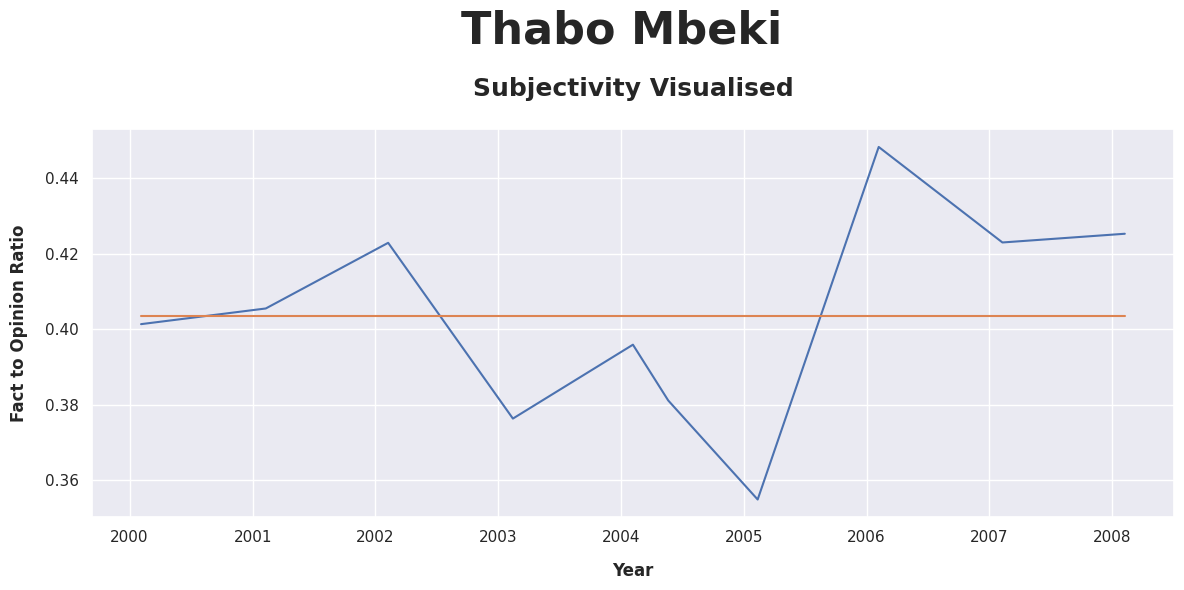

In [52]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Thabo Mbeki"),
    sentiment=subjectivity,
    president="Thabo Mbeki",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>As per his own average, <b><i>Thabo Mbeki</i></b> looks to have made two major deviations</li>
    <br />
    <li>The minor dip following the <b><i>2004</i></b> elections is in keeping with the previously made observation of <b><i>Subjectivity</i></b> dropping post elections</li>
    <br />
    <li><b><i>2005</i></b> saw an increase in facts when delivering his speech, something like <b><i>5%</i></b></li>
    <br />
    <li><b><i>2006</i></b> also had a <b><i>5%</i></b> shift from the mean, though this time showed an increase in opinion</li>
    <br />
    <li>Furthermore, the latter years of the presidency showed more opinion than the personalised average</li>
    <br />
    <li>This is in keeping with our findings when looking across all terms, that is, (a) we have more facts than opinion, (b) General Elections lead to an increase in facts for the speech following said elections and (c) the end of term sees a rapid increase in opinion, though the speech still remains mostly factual</li>
</ul>

<br />
<br />


<h5 align="center">Thabo Mbeki</h5>
<h5 align="center">Polarity</h5>

<br />
<br />


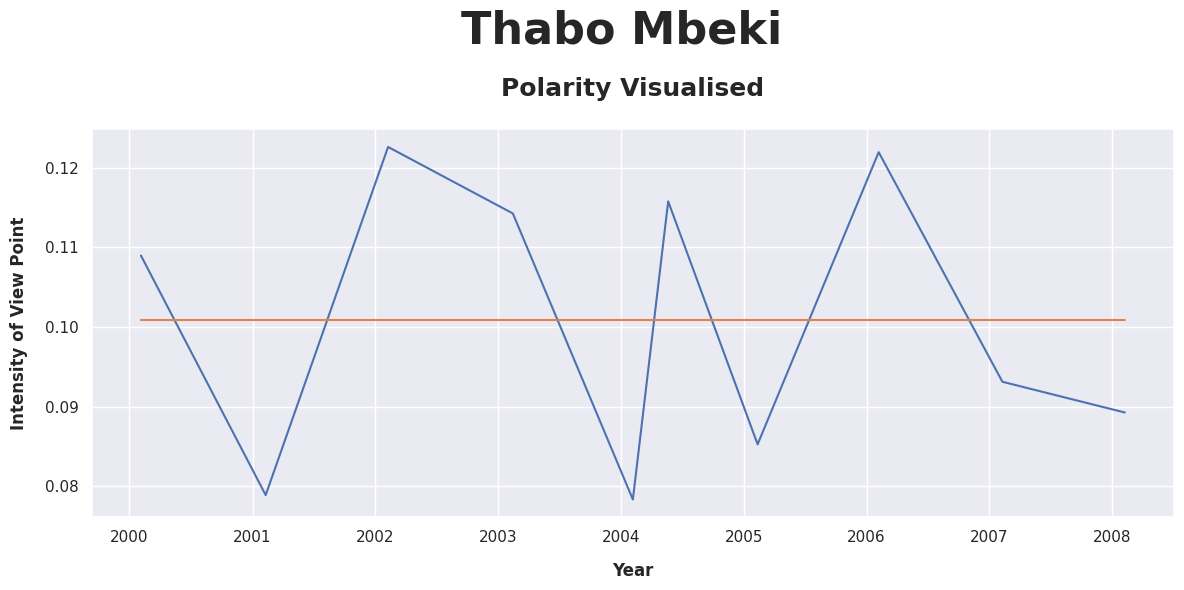

In [53]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Thabo Mbeki"),
    sentiment=polarity,
    president="Thabo Mbeki",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>We have a mean of approx. <b><i>10%</i></b></li>
    <br />
    <li>Though the speeches alternate between being below and above the mean practically every year, the deviation, about <b><i>2%</i></b> has one regarding these as negligible</li>
    <br />
    <li><b><i>Thabo Mbeki's</i></b> viewpoint though a minor value is at the least positive</li>
    <br />
    <li>With the mean in mind, here we have a positive sentiment within a regular range of <b><i>8-12%</i></b>; having no knowledge of the difficulties that come with running a country, I would much sooner assume that this ebb and flow are but part thereof</li>
</ul>

<br />
<br />


<h5 align="center">Kgalema Motlanthe</h5>
<h5 align="center">Subjectivity and Polarity</h5>

<br />
<br />


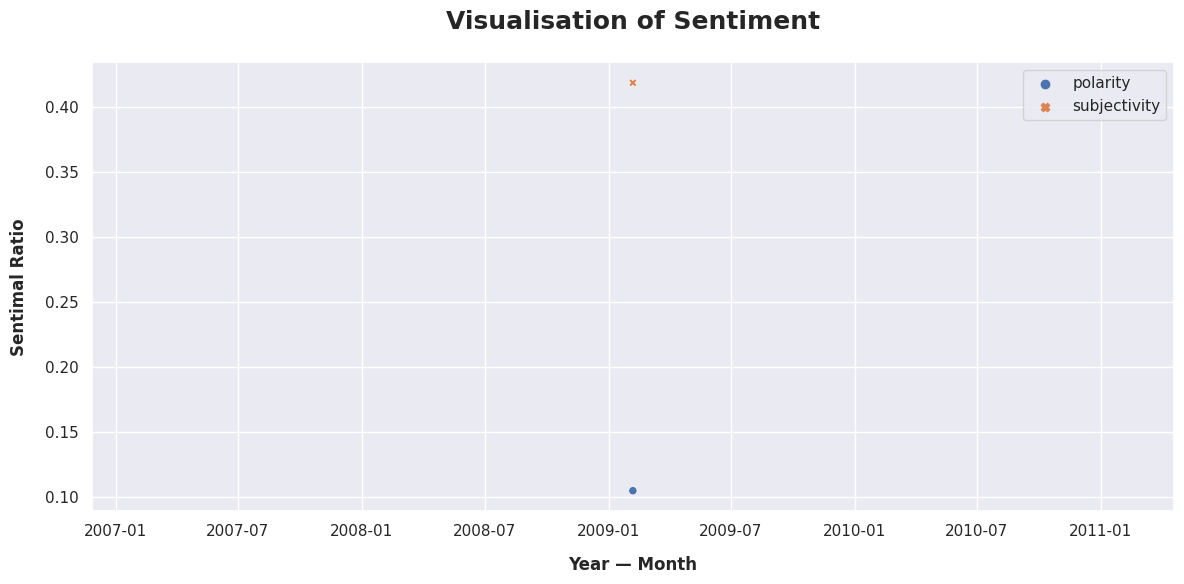

In [54]:
sns.scatterplot(
    data=get_presidential_sentiment(speeches, "Kgalema Motlanthe"),
).set(
    title="Visualisation of Sentiment",
    xlabel="Year — Month",
    ylabel="Sentimal Ratio",
)

plt.tight_layout()
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>This was an <b><i>Eight Month</i></b> long temporary presidency: September 2008 - May 2009</li>
    <br />
    <li>The second since the <b><i>1993</i></b> step down in preparation for wholly inclusive rule</li>
    <br />
    <li>The <b><i>Subjectivity</i></b> is pretty high, almost as though it is a continuation of <b><i>Thabo Mbeki's</i></b></li>
    <br />
    <li><b><i>Polarity</i></b> is the bog-standard <b><i>10%</i></b></li>
    <br />
    <li>At the risk of sounding like a skipping record, these are in essence a continuation of the figures of <b><i>Thabo Mbeki</i></b></li>
</ul>

<br />
<br />


<h5 align="center">Jacob Zuma</h5>
<h5 align="center">Subjectivity</h5>

<br />
<br />


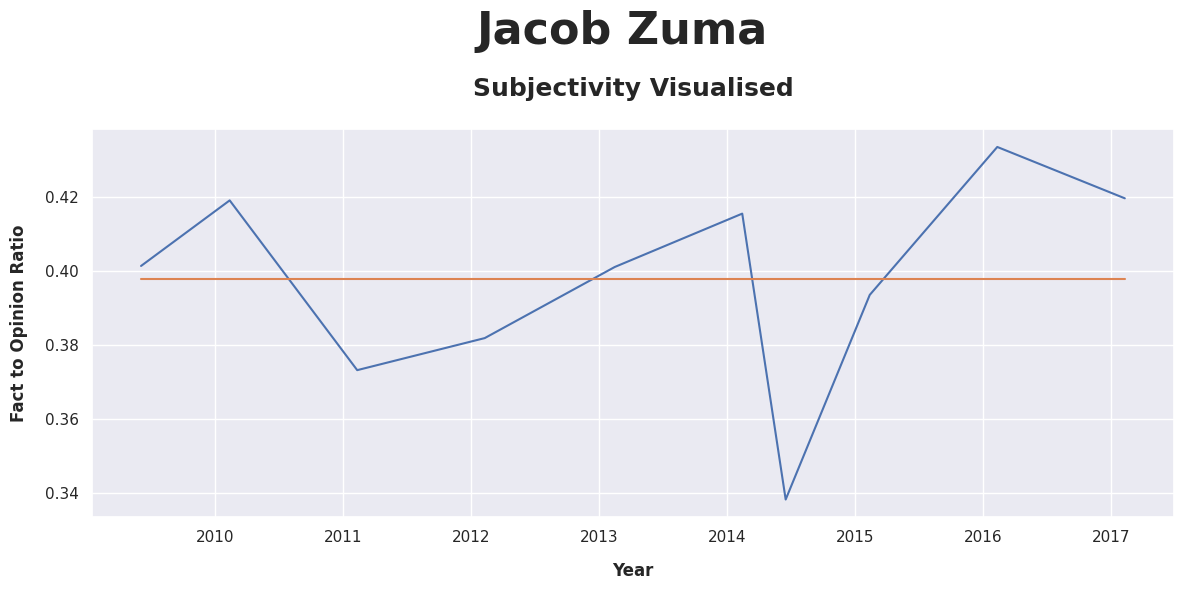

In [55]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Jacob Zuma"),
    sentiment=subjectivity,
    president="Jacob Zuma",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>Here the subjectivity is pretty similar to that of <b><i>Thabo Mbeki</i></b> and the whole, averaging at about <b><i>40%</i></b> with a deviation of about <b><i>4%</i></b></li>
    <br />
    <li>Note that <b><i>2014</i></b> has a sharp decline after the second presidential speech for that year, of interest is that this was at the height of the <b><i>Nkandla Homestead</i></b> having been made public</li>
    <br />
    <li>As with <b><i>Thabo Mbeki</i></b>, the last three years saw an increase in personal opinion</li>
    <br />
    <li>An interesting matter is how <b><i>2011</i></b> also saw lower than average <b><i>Subjectivity</i></b>, perhaps the <a href="https://www.gcis.gov.za/sites/default/files/docs/resourcecentre/pocketguide/2010/008_economy.pdf">June 2010 Fortune/Time/CNN Global Forum</a> provided both more factual and economically related topics — see how <b><i>Work</i></b> and <b><i>Infrastructure</i></b> make his <b><i>Top-Five</i></b> words for this year</li>
</ul>

<br />
<br />


<h5 align="center">Jacob Zuma</h5>
<h5 align="center">Polarity</h5>

<br />
<br />


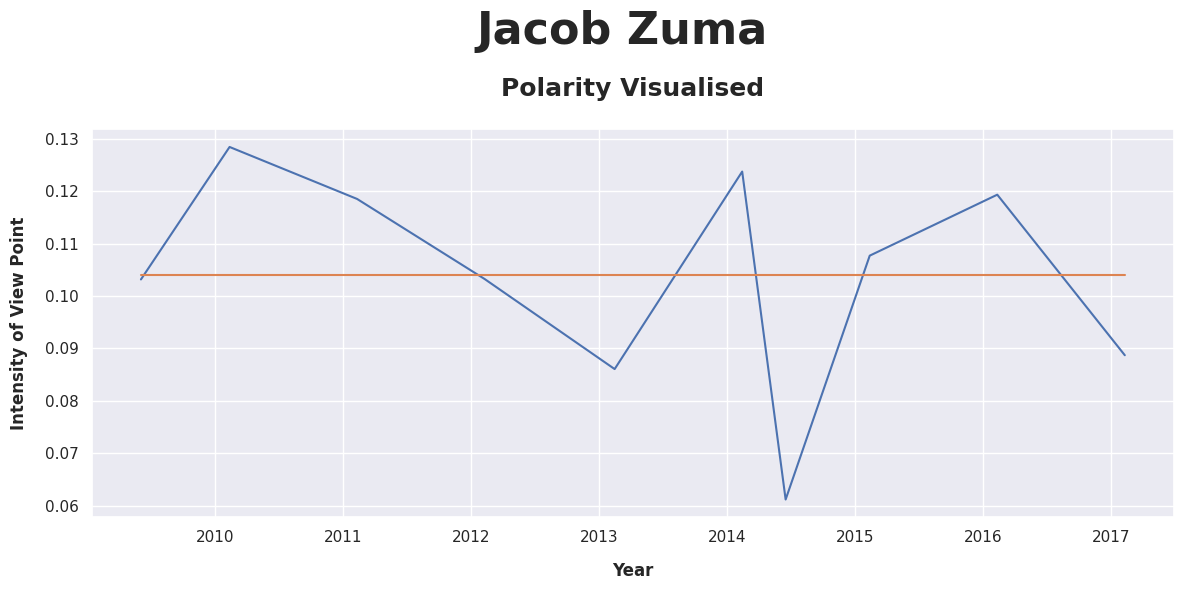

In [56]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Jacob Zuma"),
    sentiment=polarity,
    president="Jacob Zuma",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>Again, this is similar to <b><i>Thabo Mbeki's</i></b> results, having a mean of approx. <b><i>10%</i></b></li>
    <br />
    <li>Prior to <b><i>2012</i></b>, we see a higher intensity in viewpoint and this interestingly is about the time that the <b><i>Nkandla</i></b> rumours surfaced</li>
    <br />
    <li>Everything after is topsy-turvy, at worst, having a drawdown of about <b><i>4%</i></b></li>
    <br />
    <li>Regardless of all the above, the presidency, as per the speeches, maintained positive polarity</li>
</ul>

<br />
<br />


<h5 align="center">Cyril Ramaphosa</h5>
<h5 align="center">Subjectivity</h5>

<br />
<br />


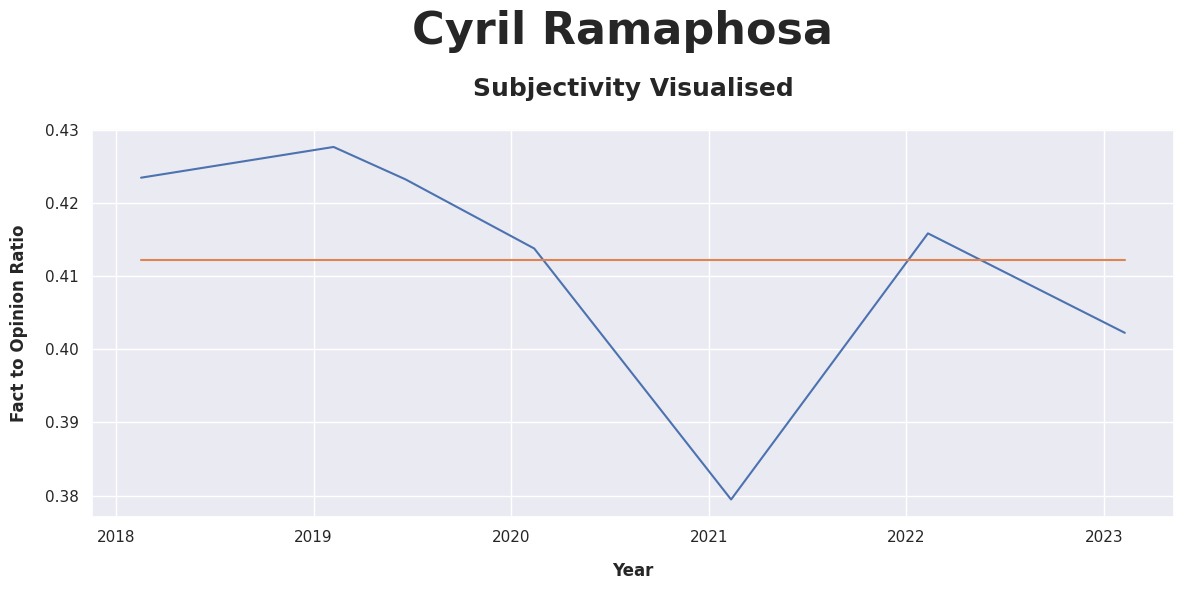

In [57]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Cyril Ramaphosa"),
    sentiment=subjectivity,
    president="Cyril Ramaphosa",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>Here we follow a similar theme regarding numbers; an average of about <b><i>41.5%</i></b> with a deviation of about <b><i>2%</i></b></li>
    <br />
    <li>As with <b><i>Thabo Mbeki</i></b> and <b><i>Jacob Zuma</i></b>, we see a steep dip during the presidency, presumably a result of the fallout caused by the <b><i>2020</i></b> <b><i>Covid-19</i></b> outbreak</li>
    <br />
    <li>This year, <b><i>2023</i></b> has seen another dip and considering how words such as <b><i>Crisis</i></b> made the wordcloud, this is no surprise</li>
    <br />
    <li>The term beginning with such high <b><i>Subjectivity</i></b> (opinion) may have been influenced by the resignation of <b><i>Jacob Zuma</i></b> in <b><i>2018</i></b></li>
</ul>

<br />
<br />


<h5 align="center">Cyril Ramaphosa</h5>
<h5 align="center">Polarity</h5>

<br />
<br />


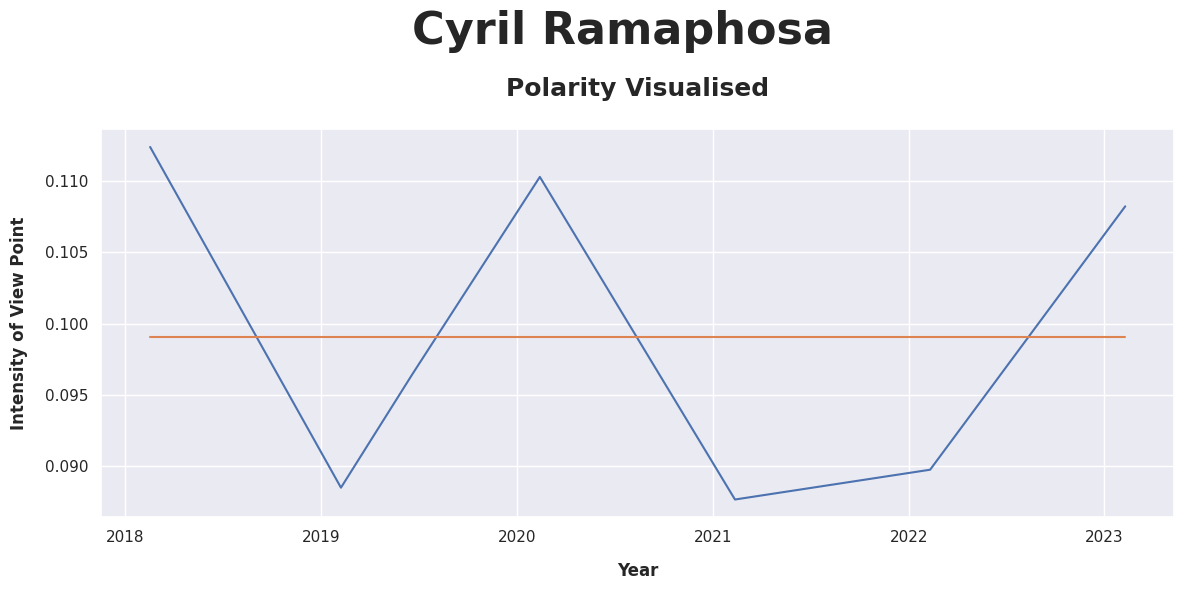

In [58]:
plot_sentiment(
    source=get_presidential_sentiment(speeches, "Cyril Ramaphosa"),
    sentiment=polarity,
    president="Cyril Ramaphosa",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>We have an average just below <b><i>10%</i></b> and a wild deviation, similar to <b><i>Thabo Mbeki's</i></b></li>
    <br />
    <li>As with <b><i>Subjectivity</i></b>, we begin hot, yet within a yet drop below the individuated average</li>
    <br />
    <li>Draw your eye to <b><i>2019</i></b>, another election year seeing a dip; yet the second speech that year actually made an upturn, a rare event</li>
    <br />
    <li><b><i>2021</i></b> sees the lowest value, about equal to <b><i>Thabo Mbeki's</i></b> lowest</li>
    <br />
    <li>When going through our wordclouds, we had predicted a negative sentimental analysis for the year <b><i>2023</i></b>; here we see that <b><i>Polarity</i></b> is a slight positive, yet lower than <b><i>Ramaphosa's</i></b> own mean. As such, the sentiment is still slightly positive, though lower than the average of his prior year</li>
    <br />
    <li>As with all the other presidents, the first address is highly opinionated; should more speeches follow, we are presented with more facts than opinions. Elections (see 2019) and world events (2008 and 2021 following the March 2020 shutdown) cause an immediate addition of facts into speeches.</li>
</ul>

<br />
<br />


<h1 align="Center">The Elephant in the Room</h1>

<br />
<br />


<p><b><i>Jacob Zuma</i></b> is quite the quandary. His top words are all positive, a summation being <b><i>Government</i></b>, <b><i>Work</i></b>, <b><i>Development</i></b>, <b><i>Honourable</i></b>, <b><i>Infrastructure</i></b> and <b><i>Compatriot</i></b>. Though as mentioned before, his presidency did see a negative downturn, which still haunts us to this day as alleged by the <a href="https://mg.co.za/top-six/2022-02-02-how-the-guptas-captured-transnet/">Transnet-Guptas Scandal</a>.</p>

<p>So here's a proposal, let us see what happens to his results when we cull the <b><i>Top-Five</i></b> words constantly used. The rationale is that the State of the Nation does not correlate with the wordage. Secondly, he often uses words such as <b><i>Honourable</i></b> and <b><i>Compatriot</i></b> as greetings, offering further reasoning.</p>

<br />
<br />


<h5 align="center">Removal of Zuma's Stop Words</h5>

<br />
<br />


In [59]:
zuma_mask = speeches.president == "Jacob Zuma"
zuma = speeches[zuma_mask].copy(deep=True)

zuma_top_five_per_speech = [
    Counter(speech).most_common()[:5]
    for speech in zuma.tokenized
]

zuma_stop_words = set(
    word
    for speech in zuma_top_five_per_speech
    for word, _ in speech
)

zuma.tokenized = zuma.tokenized.apply(
    remove_stop_words, args=(zuma_stop_words,)
)


zuma_word_count_prior_deconcatination = unique_word_counter(zuma.speech)
zuma.speech =  zuma.tokenized.apply(concat_speech)
zuma_word_count_post_deconcatination = unique_word_counter(zuma.speech)

assert zuma_word_count_prior_deconcatination > zuma_word_count_post_deconcatination


<br />

<h5 align="center">Zuma Document-Term Matrix</h5>

<br />
<br />


In [60]:
zuma_vectorizer = CountVectorizer(stop_words="english")

zuma_vector = zuma_vectorizer.fit_transform(zuma.speech).toarray()

zuma_doc_term_matrix = pd.DataFrame(
    data=zuma_vector,
    index=zuma.index,
    columns=zuma_vectorizer.get_feature_names_out(),
)


<br />

<h5 align="center">Zuma's Sentiment</h5>

<br />
<br />


In [61]:
zuma["polarity"] = zuma.speech.apply(
    lambda speech: english_nlp(speech)._.blob.polarity
)

zuma["subjectivity"] = zuma.speech.apply(
    lambda words: english_nlp(words)._.blob.subjectivity
)


<br />

<h5 align="center">Zuma's Augmented Word Cloud</h5>

<br />
<br />


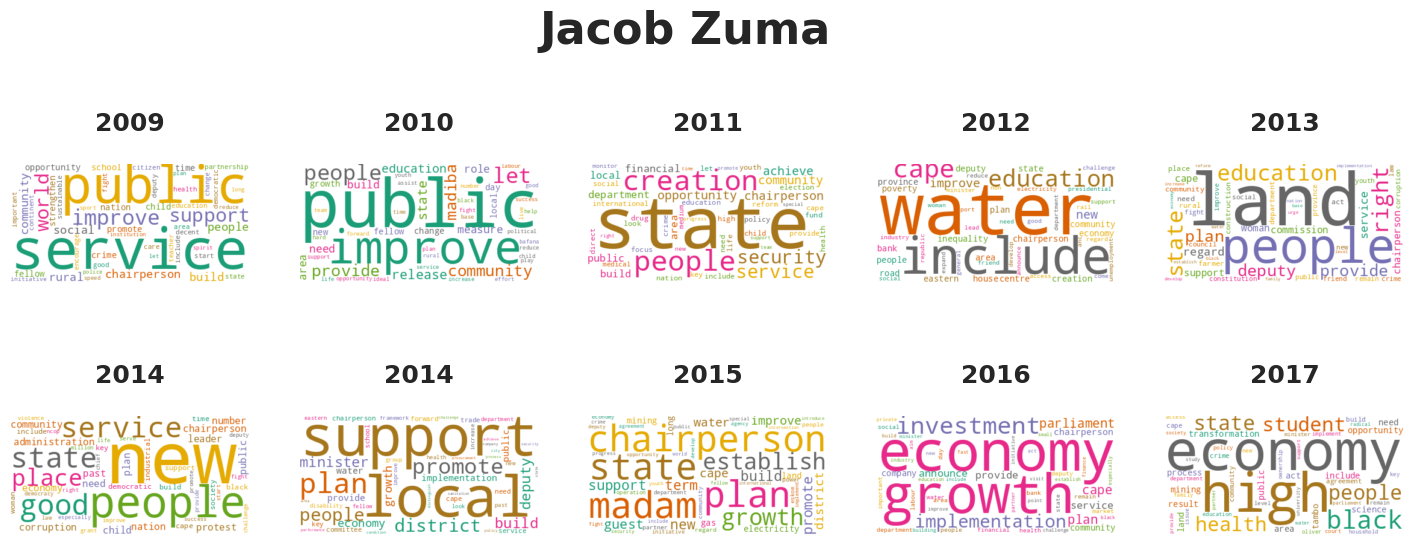

In [62]:
nrows =2
ncols = 5

fig_03, _ = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6))

for index, year in enumerate(zuma_doc_term_matrix.index, start=1):
    word_cloud.generate(
        " ".join(zuma_doc_term_matrix.loc[year].nlargest(50).index)
    )
    
    plt.subplot(nrows, ncols, index)
    plt.axis("off")
    plt.imshow(
        X=word_cloud,
        interpolation="bilinear",
        interpolation_stage="rgba"
    )

    plt.title(year.year)

fig_03.suptitle("Jacob Zuma", y=1.0625)

plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>As per the speeches, <b><i>Jacob Zuma</i></b> should be considered honourable</li>
    <br />
    <li>The primary words look to focus on the backbone of what would lead to <b><i>Development</i></b></li>
    <br />
    <li>Furthermore, none of the remaining words look to be related to greetings</li>
</ul>

<br />
<br />


<h5 align="center">Zuma's Augmented Top-Five Words</h5>

<br />
<br />


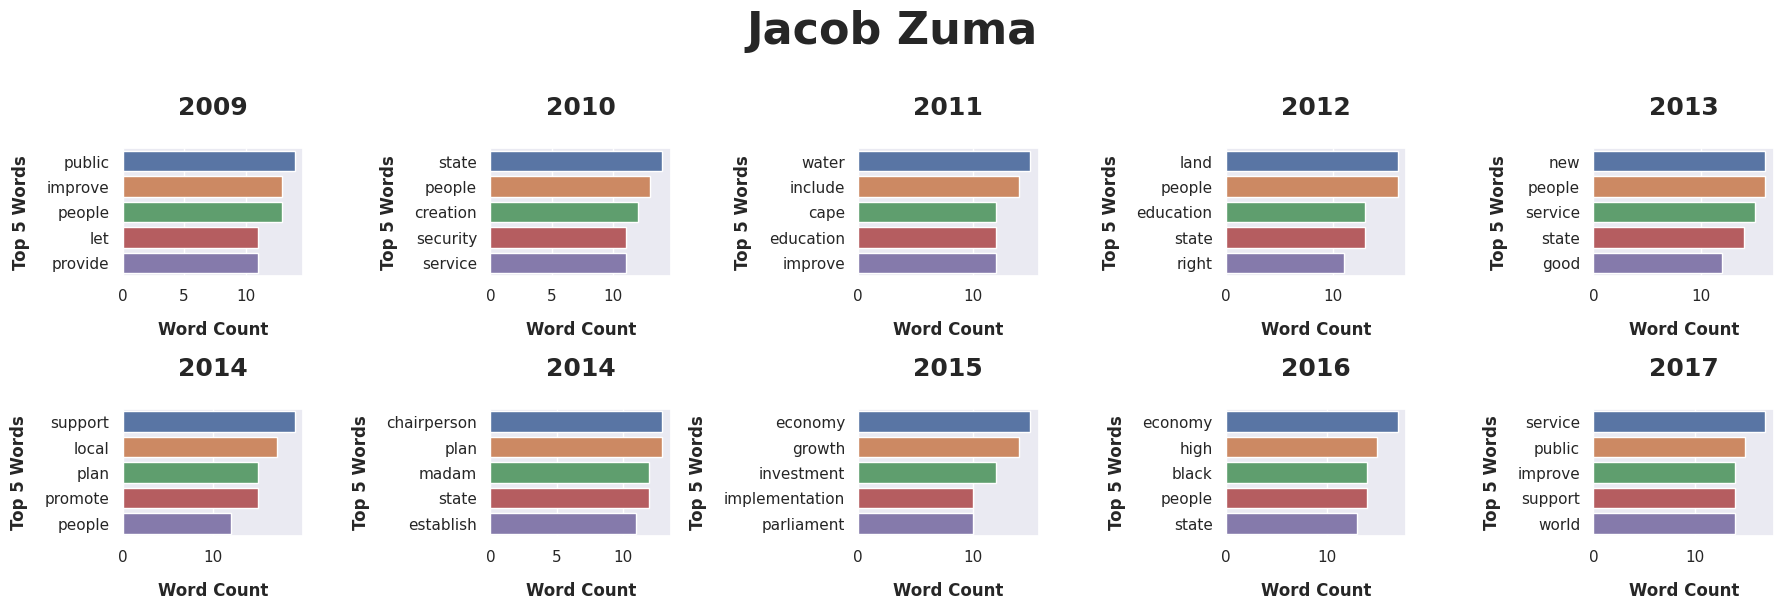

In [63]:
fig_03, _ = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6))

for index, year in enumerate(zuma_doc_term_matrix.index, start=1):
    zuma_five_most_frequent = zuma_doc_term_matrix.loc[year].nlargest(5)
    sns.barplot(
        x=zuma_five_most_frequent.values,
        y=zuma_five_most_frequent.index,
    )
    
    plt.subplot(nrows, ncols, index)

    plt.title(year.year)

    plt.xlabel("Word Count")
    plt.ylabel("Top 5 Words")

fig_03.suptitle("Jacob Zuma", y=1.0125)

plt.tight_layout()
plt.show()


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>This reflects the word cloud, any statements would be redundant</li>
</ul>

<br />
<br />


<h5 align="center">Zuma's Augmented Subjectivity</h5>

<br />
<br />


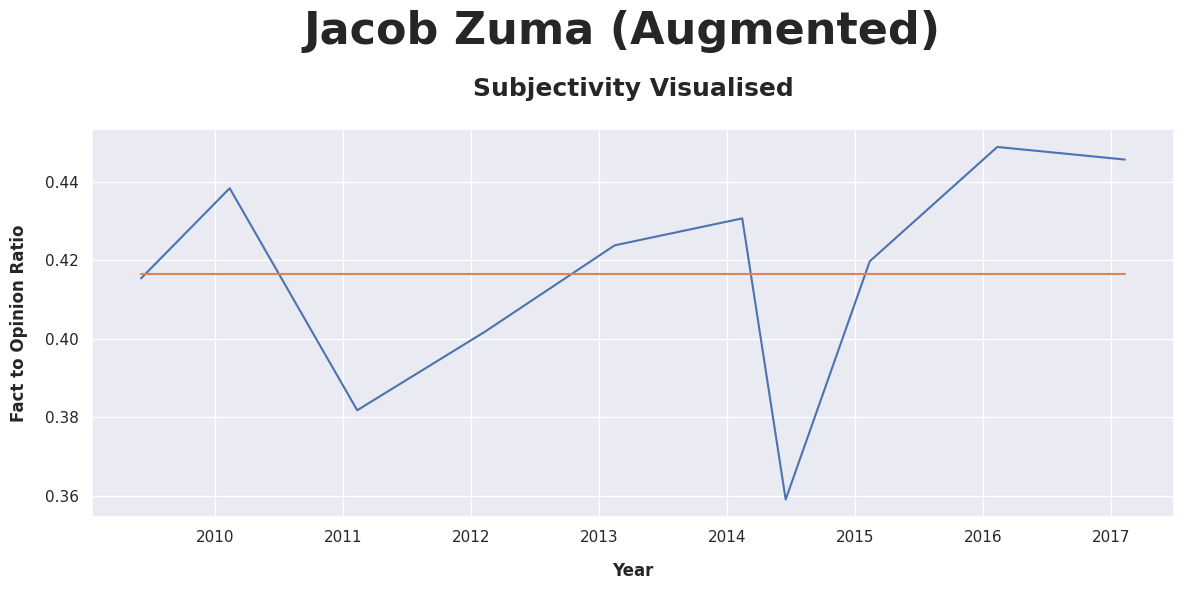

In [64]:
plot_sentiment(
    source=get_presidential_sentiment(zuma, "Jacob Zuma"),
    sentiment=subjectivity,
    president="Jacob Zuma (Augmented)",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>The mean shows a <b><i>1%</i></b> increase</li>
    <br />
    <li><b><i>2012</i></b> and <b><i>2013</i></b> are more distinguishable</li>
    <br />
    <li><b><i>Mid-2014</i></b> has risen by less than the <b><i>1%</i></b> mentioned above</li>
    <br />
    <li>The last two years have a closer <b><i>Subjectivity</i></b></li>
    <br />
    <li>For the most part, the shape is intact</li>
</ul>

<br />
<br />


<h5 align="center">Zuma's Augmented Polarity</h5>

<br />
<br />


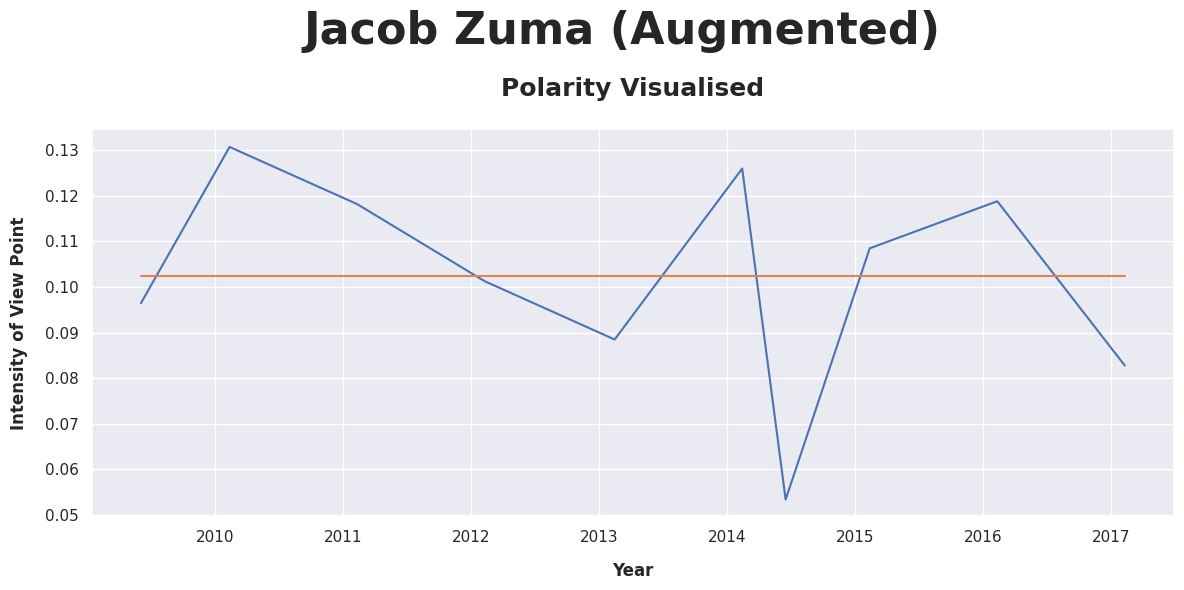

In [65]:
plot_sentiment(
    source=get_presidential_sentiment(zuma, "Jacob Zuma"),
    sentiment=polarity,
    president="Jacob Zuma (Augmented)",
)


<br />

<h5 align="Center">Observations</h5>

<br />

<ul>
    <li>We see a reduction in <b><i>Polarity</i></b></li>
    <br />
    <li><b><i>2012</i></b> and <b><i>2016</i></b> dropped about <b><i>0.5%</i></b></li>
    <br />
    <li>Midway through <b><i>2014</i></b> we see the sharpest drop, that being roughly <b><i>1%</i></b></li>
    <br />
    <li>All in all, the same remains intact</li>
</ul>

<br />
<br />


<h1 align="Center">Conclusion</h1>

<br />
<br />


<p>Times have changed. The men at the helm of the country have changed. Yet, the state of the nation looks to have been stunted. As demonstrated by the word clouds, the primary focus has been on the <b><i>Government</i></b>, <b><i>People</i></b> and <b><i>Business</i></b>.</p>

<p>Even with the above principle concerns, even with the change in helmsmen, there looks to have been no increase in <b><i>Polarity</i></b>, perhaps the best way to get a sense of a president's outlook on the outcome of the outgoing year.</p>

<p>As per the data, <b><i>Subjectivity</i></b> and <b><i>Polarity</i></b>, there has been little sentimental change over the year. Variations being in the region of <b><i>5%</i></b> and <b><i>2%</i></b> respectively. Our <b><i>Word Clouds</i></b> and <b><i>Top-Five</i></b> lists show a similar fact. Novel areas of focus look to disappear by the next speech, such as <b><i>Infrastructure</i></b>. In short, the men change, as per the speeches, the focus remains firmly rooted in speaking of the <b><i>Government</i></b>, the <b><i>People</i></b>, <b><i>Development</i></b> and the country continues to deteriorate.</p>

<p>Lest we rush in with eyes full of anger and rage, consider that the state of the nation is not composed in isolation, but within the whirlwind that is the world economy. Add to that the increase in child survival rates, increased life spans, increased population and reduction in resources as a launchpad, and it does become easy to conceive of ideas as to the stunted <b><i>Polarity</i></b>.</p>

<br />
<br />
